**Unbalanced Datset**


In [1]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
 94%|███████████████████████████████████▋  | 62.0M/66.0M [00:01<00:00, 37.2MB/s]
100%|██████████████████████████████████████| 66.0M/66.0M [00:01<00:00, 34.8MB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [3]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours

In [4]:
df = pd.read_csv('creditcard.csv')

In [5]:
# Scaling the 'Amount' feature and normalizing the 'Time' feature
from sklearn.preprocessing import RobustScaler
new_df = df.copy()
new_df['Amount'] = RobustScaler().fit_transform(new_df['Amount'].to_numpy().reshape(-1, 1))
time = new_df['Time']
new_df['Time'] = (time - time.min()) / (time.max() - time.min())

In [6]:
# Shuffling the data and splitting into train, validation, and test sets
new_df = new_df.sample(frac=1, random_state=1)
train, test, val = new_df[:240000], new_df[240000:262000], new_df[262000:]


In [7]:
# Extracting features and labels
train_np, test_np, val_np = train.to_numpy(), test.to_numpy(), val.to_numpy()
x_train, y_train = train_np[:, :-1], train_np[:, -1]
x_test, y_test = test_np[:, :-1], test_np[:, -1]
x_val, y_val = val_np[:, :-1], val_np[:, -1]

In [8]:
# Scale the data and fit the model
logistic_model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Fit the model
logistic_model.fit(x_train, y_train)

# Print the classification report
print("Logistic Regression (Unbalanced Data)")
print(classification_report(y_val, logistic_model.predict(x_val), target_names=['Not Fraud', 'Fraud']))


Logistic Regression (Unbalanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.73      0.53      0.61        36

    accuracy                           1.00     22807
   macro avg       0.87      0.76      0.81     22807
weighted avg       1.00      1.00      1.00     22807



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/5


I0000 00:00:1724765757.827586     129 service.cc:145] XLA service 0x7b1708006c40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724765757.827646     129 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 109/7500 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - accuracy: 0.6865 - loss: 0.8288 

I0000 00:00:1724765758.728725     129 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


7500/7500 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9620 - loss: 0.1612 - val_accuracy: 0.9990 - val_loss: 0.0085
Epoch 2/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9993 - loss: 0.0036 - val_accuracy: 0.9991 - val_loss: 0.0092
Epoch 3/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9992 - val_loss: 0.0078
Epoch 4/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9994 - loss: 0.0030 - val_accuracy: 0.9992 - val_loss: 0.0097
Epoch 5/5
7500/7500 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step - accuracy: 0.9994 - loss: 0.0031 - val_accuracy: 0.9992 - val_loss: 0.0079


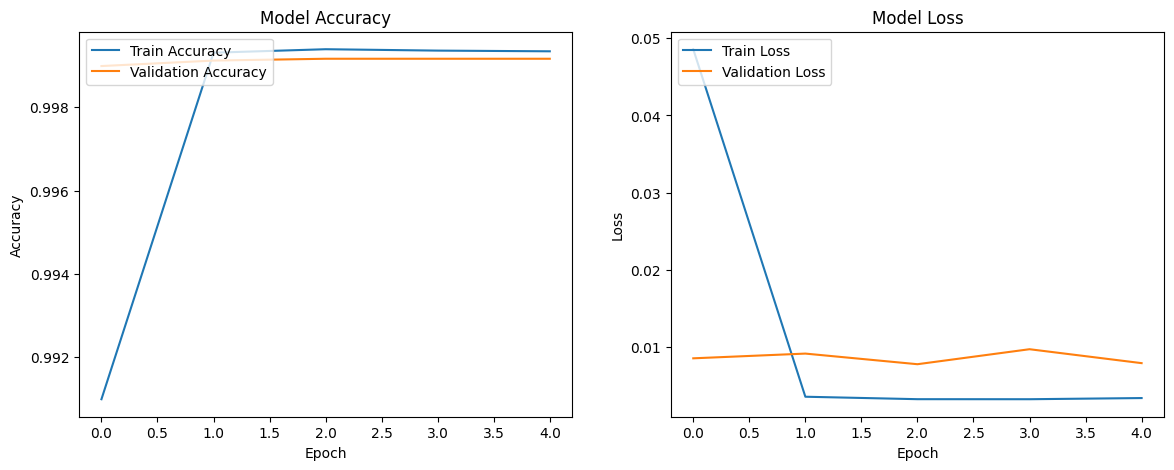

In [9]:
import matplotlib.pyplot as plt

# Train the shallow neural network
shallow_nn = Sequential()
shallow_nn.add(InputLayer(input_shape=(x_train.shape[1],)))
shallow_nn.add(Dense(2, activation='relu'))
shallow_nn.add(BatchNormalization())
shallow_nn.add(Dense(1, activation='sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn.keras', save_best_only=True)
shallow_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = shallow_nn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, callbacks=[checkpoint])

def neural_net_predictions(model, x):
    return (model.predict(x).flatten() > 0.5).astype(int)

# Plot accuracy and loss
def plot_training_history(history):
    # Plotting training & validation accuracy values
    plt.figure(figsize=(14, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

plot_training_history(history)


In [10]:
print("Shallow Neural Network (Unbalanced Data)")
print(classification_report(y_val, neural_net_predictions(shallow_nn, x_val), target_names=['Not Fraud', 'Fraud']))


Shallow Neural Network (Unbalanced Data)
713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.73      0.75      0.74        36

    accuracy                           1.00     22807
   macro avg       0.86      0.87      0.87     22807
weighted avg       1.00      1.00      1.00     22807



In [11]:
# RandomForest on Unbalanced Data
rf = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf.fit(x_train, y_train)
print("Random Forest (Unbalanced Data)")
print(classification_report(y_val, rf.predict(x_val), target_names=['Not Fraud', 'Fraud']))


Random Forest (Unbalanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.81      0.47      0.60        36

    accuracy                           1.00     22807
   macro avg       0.90      0.74      0.80     22807
weighted avg       1.00      1.00      1.00     22807



In [12]:
# GradientBoostingClassifier on Unbalanced Data

gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc.fit(x_train, y_train)
print("Gradient Boosting (Unbalanced Data)")
print(classification_report(y_val, gbc.predict(x_val), target_names=['Not Fraud', 'Fraud']))


Gradient Boosting (Unbalanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.67      0.67      0.67        36

    accuracy                           1.00     22807
   macro avg       0.83      0.83      0.83     22807
weighted avg       1.00      1.00      1.00     22807



In [13]:
# LinearSVC on Unbalanced Data

svc = LinearSVC(class_weight='balanced')
svc.fit(x_train, y_train)
print("Linear SVC (Unbalanced Data)")
print(classification_report(y_val, svc.predict(x_val), target_names=['Not Fraud', 'Fraud']))


Linear SVC (Unbalanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.63      0.75      0.68        36

    accuracy                           1.00     22807
   macro avg       0.81      0.87      0.84     22807
weighted avg       1.00      1.00      1.00     22807



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [14]:
# Generate classification reports for each model
logistic_report_u = classification_report(y_val, logistic_model.predict(x_val), target_names=['Not Fraud', 'Fraud'])
neural_net_report_u = classification_report(y_val, neural_net_predictions(shallow_nn, x_val), target_names=['Not Fraud', 'Fraud'])
rf_report_u = classification_report(y_val, rf.predict(x_val), target_names=['Not Fraud', 'Fraud'])
gbc_report_u = classification_report(y_val, gbc.predict(x_val), target_names=['Not Fraud', 'Fraud'])
svc_report_u = classification_report(y_val, svc.predict(x_val), target_names=['Not Fraud', 'Fraud'])


713/713 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [15]:
# Summary of Unbalanced Dataset Models
print("\nSummary Report for Unbalanced Dataset Models:")
print("\nLogistic Regression:\n", logistic_report_u)
print("\nNeural Network:\n", neural_net_report_u)
print("\nRandom Forest:\n", rf_report_u)
print("\nGradient Boosting Classifier:\n", gbc_report_u)
print("\nSVM:\n", svc_report_u)



Summary Report for Unbalanced Dataset Models:

Logistic Regression:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.73      0.53      0.61        36

    accuracy                           1.00     22807
   macro avg       0.87      0.76      0.81     22807
weighted avg       1.00      1.00      1.00     22807


Neural Network:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.73      0.75      0.74        36

    accuracy                           1.00     22807
   macro avg       0.86      0.87      0.87     22807
weighted avg       1.00      1.00      1.00     22807


Random Forest:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     22771
       Fraud       0.81      0.47      0.60        36

    accuracy                           1.00     22807
   macro avg       0.90

**Balanced data ( Random Undersampling)**

In [16]:
not_frauds = new_df.query('Class == 0')
frauds = new_df.query('Class == 1')
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df_np = balanced_df.to_numpy()

In [17]:
# Split balanced dataset into train, test, and validation sets
x_train_b, y_train_b = balanced_df_np[:700, :-1], balanced_df_np[:700, -1].astype(int)
x_test_b, y_test_b = balanced_df_np[700:842, :-1], balanced_df_np[700:842, -1].astype(int)
x_val_b, y_val_b = balanced_df_np[842:, :-1], balanced_df_np[842:, -1].astype(int)


In [18]:
# Logistic Regression on Balanced Data
logistic_model_b = LogisticRegression()
logistic_model_b.fit(x_train_b, y_train_b)
logistic_b_report = classification_report(y_val_b, logistic_model_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud'])
print("Logistic Regression on Balanced Data")
print(logistic_b_report)


Logistic Regression on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.96      0.93      0.94        72
       Fraud       0.93      0.96      0.94        70

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142



Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.8208 - loss: 0.5452 - val_accuracy: 0.7958 - val_loss: 0.4562
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8455 - loss: 0.5195 - val_accuracy: 0.8732 - val_loss: 0.4390
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8577 - loss: 0.5015 - val_accuracy: 0.8944 - val_loss: 0.4276
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8510 - loss: 0.4842 - val_accuracy: 0.9366 - val_loss: 0.4171
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8364 - loss: 0.4836 - val_accuracy: 0.9296 - val_loss: 0.4085
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8800 - loss: 0.4533 - val_accuracy: 0.9366 - val_loss: 0.4049
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8448 - loss: 0.4749 - val_accuracy: 0.9366 - val_loss: 0.4007
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8821 - loss: 0.4377 - val_accuracy: 0.9225 - val_loss: 0.

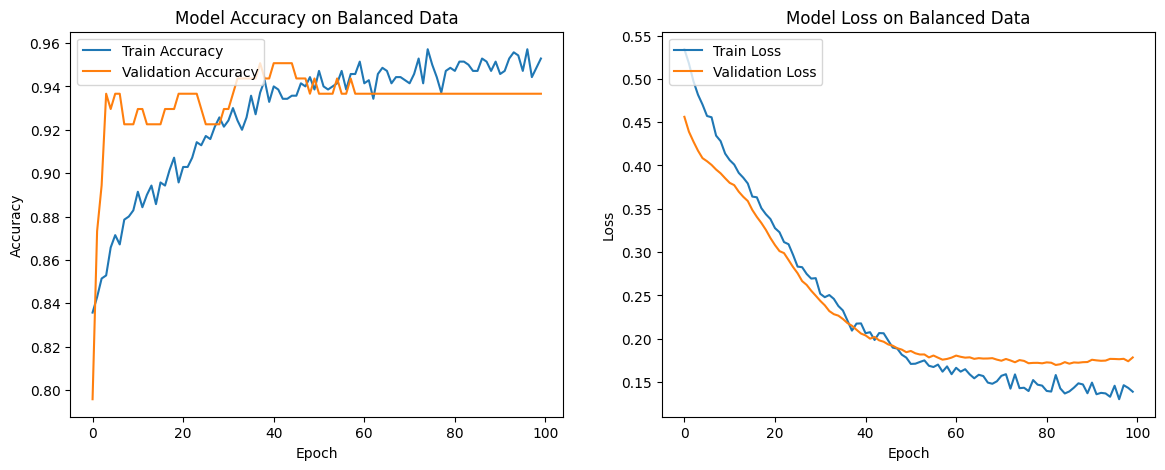

In [19]:
import matplotlib.pyplot as plt

# Train the shallow neural network on balanced data
shallow_nn_b = Sequential()
shallow_nn_b.add(InputLayer(input_shape=(x_train_b.shape[1],)))
shallow_nn_b.add(Dense(2, activation='relu'))
shallow_nn_b.add(BatchNormalization())
shallow_nn_b.add(Dense(1, activation='sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn_b.keras', save_best_only=True)

shallow_nn_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_b = shallow_nn_b.fit(x_train_b, y_train_b, validation_data=(x_val_b, y_val_b), epochs=100, callbacks=[checkpoint])

neural_net_b_report = classification_report(y_val_b, neural_net_predictions(shallow_nn_b, x_val_b), target_names=['Not Fraud', 'Fraud'])
print("Neural Network on Balanced Data")
print(neural_net_b_report)

# Plotting the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history_b)


In [20]:
# Random Forest on Balanced Data
rf_b = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_b.fit(x_train_b, y_train_b)
rf_b_report = classification_report(y_val_b, rf_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud'])
print("Random Forest on Balanced Data")
print(rf_b_report)

Random Forest on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.92      0.99      0.95        72
       Fraud       0.98      0.91      0.95        70

    accuracy                           0.95       142
   macro avg       0.95      0.95      0.95       142
weighted avg       0.95      0.95      0.95       142



In [21]:
# Gradient Boosting Classifier on Balanced Data
gbc_b = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=2, random_state=0)
gbc_b.fit(x_train_b, y_train_b)
gbc_b_report = classification_report(y_val_b, gbc_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud'])
print("Gradient Boosting Classifier on Balanced Data")
print(gbc_b_report)


Gradient Boosting Classifier on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.94      0.92      0.93        72
       Fraud       0.92      0.94      0.93        70

    accuracy                           0.93       142
   macro avg       0.93      0.93      0.93       142
weighted avg       0.93      0.93      0.93       142



In [22]:
# SVM on Balanced Data
svc_b = LinearSVC(class_weight='balanced')
svc_b.fit(x_train_b, y_train_b)
svc_b_report = classification_report(y_val_b, svc_b.predict(x_val_b), target_names=['Not Fraud', 'Fraud'])
print("SVM on Balanced Data")
print(svc_b_report)

SVM on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.96      0.93      0.94        72
       Fraud       0.93      0.96      0.94        70

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [23]:
# Summary of Balanced( Random Undersampling) Dataset Models
print("\nSummary Report for Balanced Dataset Models:")
print("\nLogistic Regression:\n", logistic_b_report)
print("\nNeural Network:\n", neural_net_b_report)
print("\nRandom Forest:\n", rf_b_report)
print("\nGradient Boosting Classifier:\n", gbc_b_report)
print("\nSVM:\n", svc_b_report)



Summary Report for Balanced Dataset Models:

Logistic Regression:
               precision    recall  f1-score   support

   Not Fraud       0.96      0.93      0.94        72
       Fraud       0.93      0.96      0.94        70

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142


Neural Network:
               precision    recall  f1-score   support

   Not Fraud       0.96      0.92      0.94        72
       Fraud       0.92      0.96      0.94        70

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142


Random Forest:
               precision    recall  f1-score   support

   Not Fraud       0.92      0.99      0.95        72
       Fraud       0.98      0.91      0.95        70

    accuracy                           0.95       142
   macro avg       0.95  

**Balanced Data (SMOTE (Synthetic Minority Over-sampling Technique))**

In [24]:
!pip install imbalanced-learn


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [25]:
from imblearn.over_sampling import SMOTE
# Scaling and Normalizing features
from sklearn.preprocessing import RobustScaler

In [26]:
new_df = df.copy()
new_df['Amount'] = RobustScaler().fit_transform(new_df['Amount'].to_numpy().reshape(-1, 1))
time = new_df['Time']
new_df['Time'] = (time - time.min()) / (time.max() - time.min())

In [27]:
# Extract features and labels
X = new_df.drop(columns=['Class'])
y = new_df['Class']

# Split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)


In [28]:
# Apply SMOTE to the training data
smote = SMOTE(random_state=1)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
# Check the new class distribution
print("Original class distribution:\n", y_train.value_counts())

print("SMOTE class distribution:\n", pd.Series(y_train_smote).value_counts())


Original class distribution:
 Class
0    199020
1       344
Name: count, dtype: int64
SMOTE class distribution:
 Class
0    199020
1    199020
Name: count, dtype: int64


In [29]:
# Logistic Regression on SMOT data
logistic_model_smote = LogisticRegression()
logistic_model_smote.fit(x_train_smote, y_train_smote)
y_val_smote = logistic_model_smote.predict(x_test)
print("Logistic Regression with SMOTE (Balanced Data)")
print(classification_report(y_test, y_val_smote, target_names=['Not Fraud', 'Fraud']))


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression with SMOTE (Balanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     85295
       Fraud       0.06      0.92      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.98      0.99     85443



/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step - accuracy: 0.9774 - loss: 0.0623 - val_accuracy: 0.9972 - val_loss: 0.0104
Epoch 2/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9973 - loss: 0.0089 - val_accuracy: 0.9980 - val_loss: 0.0093
Epoch 3/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9980 - loss: 0.0066 - val_accuracy: 0.9983 - val_loss: 0.0082
Epoch 4/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9984 - loss: 0.0051 - val_accuracy: 0.9977 - val_loss: 0.0106
Epoch 5/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9987 - loss: 0.0043 - val_accuracy: 0.9989 - val_loss: 0.0067
Epoch 6/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9988 - loss: 0.0039 - val_accuracy: 0.9985 - val_loss: 0.0084
Epoch 7/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9989 - loss: 0.0038 - val_accuracy: 0.9977 - val_loss: 0.0105
Epoch 8/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - ac

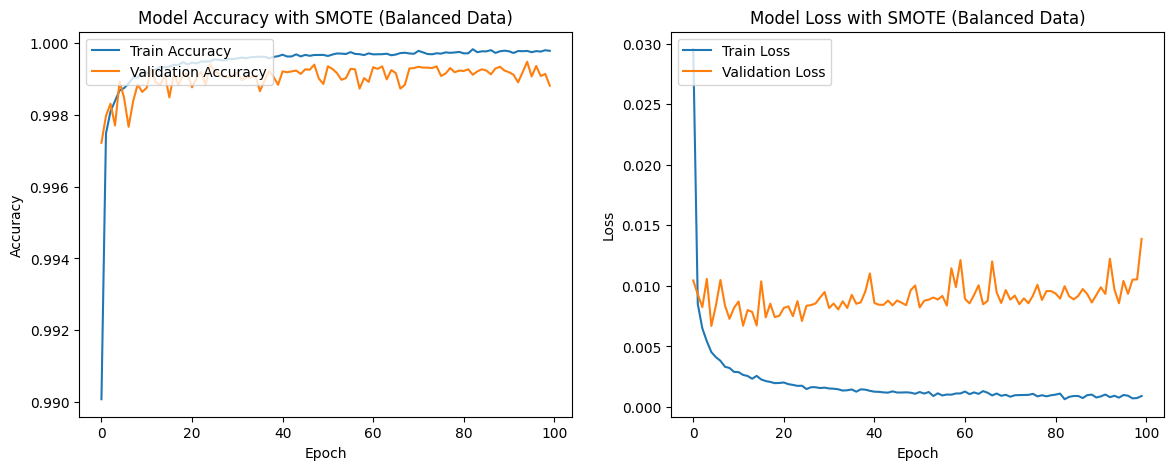

In [30]:

# Standardizing the features
scaler = StandardScaler()
x_train_smote = scaler.fit_transform(x_train_smote)
x_test = scaler.transform(x_test)

# Neural Network on SMOTE Data
shallow_nn = Sequential()
shallow_nn.add(InputLayer(input_shape=(x_train_smote.shape[1],)))
shallow_nn.add(Dense(64, activation='relu'))
shallow_nn.add(BatchNormalization())
shallow_nn.add(Dense(32, activation='relu'))
shallow_nn.add(Dense(1, activation='sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn_smote.keras', save_best_only=True)
shallow_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_smote = shallow_nn.fit(x_train_smote, y_train_smote, validation_data=(x_test, y_test), epochs=100, callbacks=[checkpoint])

def neural_net_predictions(model, x):
    return (model.predict(x).flatten() > 0.5).astype(int)

print("Neural Network with SMOTE (Balanced Data)")
print(classification_report(y_test, neural_net_predictions(shallow_nn, x_test), target_names=['Not Fraud', 'Fraud']))

# Plotting the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy with SMOTE (Balanced Data)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss with SMOTE (Balanced Data)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history_smote)

In [31]:
# Random Forest on SMOTE Data
rf_smote = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_smote.fit(x_train_smote, y_train_smote)
y_val_smote = rf_smote.predict(x_test)
print("Random Forest with SMOTE (Balanced Data)")
print(classification_report(y_test, y_val_smote, target_names=['Not Fraud', 'Fraud']))


Random Forest with SMOTE (Balanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00     85295
       Fraud       0.21      0.89      0.34       148

    accuracy                           0.99     85443
   macro avg       0.61      0.94      0.67     85443
weighted avg       1.00      0.99      1.00     85443



In [32]:
# Gradient Boosting on SMOTE Data
gbc_smote = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc_smote.fit(x_train_smote, y_train_smote)
y_val_smote = gbc_smote.predict(x_test)
print("Gradient Boosting with SMOTE (Balanced Data)")
print(classification_report(y_test, y_val_smote, target_names=['Not Fraud', 'Fraud']))


Gradient Boosting with SMOTE (Balanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      0.97      0.99     85295
       Fraud       0.06      0.93      0.11       148

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.55     85443
weighted avg       1.00      0.97      0.99     85443



In [33]:
# Linear SVC on SMOTE Data
svc_smote = LinearSVC(class_weight='balanced')
svc_smote.fit(x_train_smote, y_train_smote)
y_val_smote = svc_smote.predict(x_test)
print("Linear SVC with SMOTE (Balanced Data)")
print(classification_report(y_test, y_val_smote, target_names=['Not Fraud', 'Fraud']))


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVC with SMOTE (Balanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     85295
       Fraud       0.07      0.91      0.13       148

    accuracy                           0.98     85443
   macro avg       0.54      0.95      0.56     85443
weighted avg       1.00      0.98      0.99     85443



In [34]:
logistic_report_smote = classification_report(y_test, y_val_smote, target_names=['Not Fraud', 'Fraud'])
neural_net_report_smote = classification_report(y_test, neural_net_predictions(shallow_nn, x_test), target_names=['Not Fraud', 'Fraud'])
rf_report_smote = classification_report(y_test, rf_smote.predict(x_test), target_names=['Not Fraud', 'Fraud'])
gbc_report_smote = classification_report(y_test, gbc_smote.predict(x_test), target_names=['Not Fraud', 'Fraud'])
svc_report_smote = classification_report(y_test, svc_smote.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Print Summary
print("\nSummary Report for SMOTE-Balanced Dataset Models:")
print("\nLogistic Regression:\n", logistic_report_smote)
print("\nNeural Network:\n", neural_net_report_smote)
print("\nRandom Forest:\n", rf_report_smote)
print("\nGradient Boosting Classifier:\n", gbc_report_smote)
print("\nSVM:\n", svc_report_smote)


2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step

Summary Report for SMOTE-Balanced Dataset Models:

Logistic Regression:
               precision    recall  f1-score   support

   Not Fraud       1.00      0.98      0.99     85295
       Fraud       0.07      0.91      0.13       148

    accuracy                           0.98     85443
   macro avg       0.54      0.95      0.56     85443
weighted avg       1.00      0.98      0.99     85443


Neural Network:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.61      0.86      0.72       148

    accuracy                           1.00     85443
   macro avg       0.81      0.93      0.86     85443
weighted avg       1.00      1.00      1.00     85443


Random Forest:
               precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00     85295
       Fraud       0.21      0.89      0.34       148

    accuracy                  

**Balanced Data (ADASYN)**

In [35]:
from imblearn.over_sampling import ADASYN

# Apply ADASYN to balance the training dataset
adasyn = ADASYN(sampling_strategy='minority', random_state=1)
x_train_adasyn, y_train_adasyn = adasyn.fit_resample(x_train, y_train)


In [36]:
# Logistic Regression on ADASYN Data
logistic_model_adasyn = LogisticRegression()
logistic_model_adasyn.fit(x_train_adasyn, y_train_adasyn)
y_val_adasyn = logistic_model_adasyn.predict(x_test)
print("Logistic Regression with ADASYN (Balanced Data)")
print(classification_report(y_test, y_val_adasyn, target_names=['Not Fraud', 'Fraud']))


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Logistic Regression with ADASYN (Balanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.36      0.71      0.48       148

    accuracy                           1.00     85443
   macro avg       0.68      0.85      0.74     85443
weighted avg       1.00      1.00      1.00     85443



/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9679 - loss: 0.0892 - val_accuracy: 0.9983 - val_loss: 0.0609
Epoch 2/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9955 - loss: 0.0158 - val_accuracy: 0.9983 - val_loss: 0.0710
Epoch 3/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9964 - loss: 0.0121 - val_accuracy: 0.9983 - val_loss: 0.0797
Epoch 4/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9969 - loss: 0.0109 - val_accuracy: 0.9983 - val_loss: 0.0802
Epoch 5/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9975 - loss: 0.0091 - val_accuracy: 0.9983 - val_loss: 0.0856
Epoch 6/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9977 - loss: 0.0083 - val_accuracy: 0.9983 - val_loss: 0.0932
Epoch 7/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9977 - loss: 0.0086 - val_accuracy: 0.9983 - val_loss: 0.0973
Epoch 8/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - ac

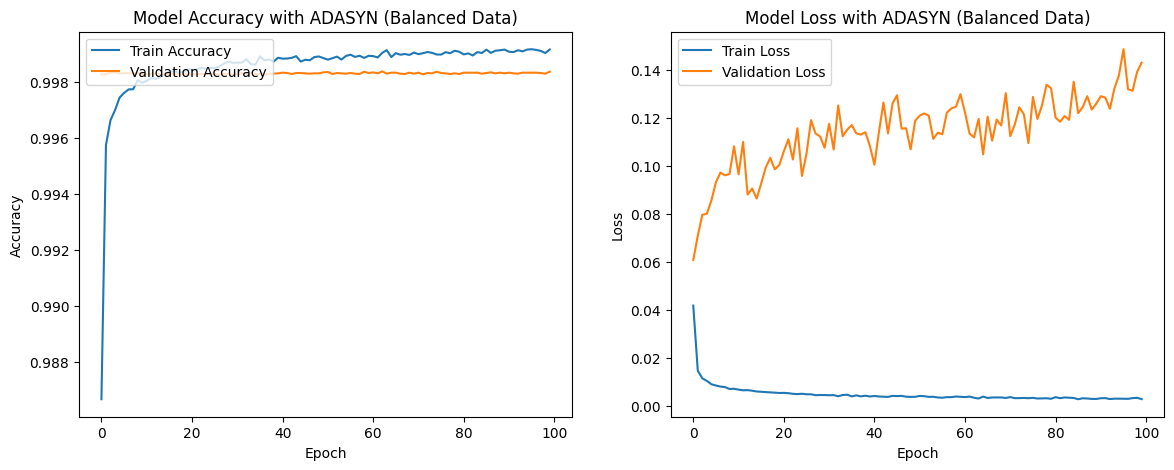

In [37]:
# Standardize data for neural network
scaler = StandardScaler()
x_train_adasyn_scaled = scaler.fit_transform(x_train_adasyn)
x_test_scaled = scaler.transform(x_test)

# Neural Network on ADASYN Data
shallow_nn_adasyn = Sequential()
shallow_nn_adasyn.add(InputLayer(input_shape=(x_train_adasyn_scaled.shape[1],)))
shallow_nn_adasyn.add(Dense(64, activation='relu'))
shallow_nn_adasyn.add(BatchNormalization())
shallow_nn_adasyn.add(Dense(1, activation='sigmoid'))

checkpoint_adasyn = ModelCheckpoint('shallow_nn_adasyn.keras', save_best_only=True)
shallow_nn_adasyn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_adasyn = shallow_nn_adasyn.fit(x_train_adasyn_scaled, y_train_adasyn, validation_data=(x_test_scaled, y_test), epochs=100, callbacks=[checkpoint_adasyn])

def neural_net_predictions(model, x):
    return (model.predict(x) > 0.5).astype(int)

print("Shallow Neural Network with ADASYN (Balanced Data)")
print(classification_report(y_test, neural_net_predictions(shallow_nn_adasyn, x_test_scaled), target_names=['Not Fraud', 'Fraud']))

# Plotting the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy with ADASYN (Balanced Data)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss with ADASYN (Balanced Data)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history_adasyn)


In [38]:
# Random Forest on ADASYN Data
rf_adasyn = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_adasyn.fit(x_train_adasyn, y_train_adasyn)
print("Random Forest with ADASYN (Balanced Data)")
print(classification_report(y_test, rf_adasyn.predict(x_test), target_names=['Not Fraud', 'Fraud']))


Random Forest with ADASYN (Balanced Data)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.82      0.51      0.62       148

    accuracy                           1.00     85443
   macro avg       0.91      0.75      0.81     85443
weighted avg       1.00      1.00      1.00     85443



In [39]:
# Gradient Boosting Classifier on ADASYN Data
gbc_adasyn = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc_adasyn.fit(x_train_adasyn, y_train_adasyn)
print("Gradient Boosting Classifier with ADASYN (Balanced Data)")
print(classification_report(y_test, gbc_adasyn.predict(x_test), target_names=['Not Fraud', 'Fraud']))


Gradient Boosting Classifier with ADASYN (Balanced Data)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.62      0.47      0.54       148

    accuracy                           1.00     85443
   macro avg       0.81      0.74      0.77     85443
weighted avg       1.00      1.00      1.00     85443



In [40]:
# SVM on ADASYN Data
svc_adasyn = LinearSVC(class_weight='balanced')
svc_adasyn.fit(x_train_adasyn, y_train_adasyn)
print("SVM with ADASYN (Balanced Data)")
print(classification_report(y_test, svc_adasyn.predict(x_test), target_names=['Not Fraud', 'Fraud']))


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


SVM with ADASYN (Balanced Data)
              precision    recall  f1-score   support

   Not Fraud       1.00      0.99      1.00     85295
       Fraud       0.15      0.72      0.25       148

    accuracy                           0.99     85443
   macro avg       0.57      0.86      0.62     85443
weighted avg       1.00      0.99      0.99     85443



In [41]:
logistic_report_adasyn = classification_report(y_test, y_val_adasyn, target_names=['Not Fraud', 'Fraud'])
neural_net_report_adasyn = classification_report(y_test, neural_net_predictions(shallow_nn_adasyn, x_test_scaled), target_names=['Not Fraud', 'Fraud'])
rf_report_adasyn = classification_report(y_test, rf_adasyn.predict(x_test), target_names=['Not Fraud', 'Fraud'])
gbc_report_adasyn = classification_report(y_test, gbc_adasyn.predict(x_test), target_names=['Not Fraud', 'Fraud'])
svc_report_adasyn = classification_report(y_test, svc_adasyn.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Print Summary
print("\nSummary Report for ADASYN-Balanced Dataset Models:")
print("\nLogistic Regression:\n", logistic_report_adasyn)
print("\nNeural Network:\n", neural_net_report_adasyn)
print("\nRandom Forest:\n", rf_report_adasyn)
print("\nGradient Boosting Classifier:\n", gbc_report_adasyn)
print("\nSVM:\n", svc_report_adasyn)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(



Summary Report for ADASYN-Balanced Dataset Models:

Logistic Regression:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.36      0.71      0.48       148

    accuracy                           1.00     85443
   macro avg       0.68      0.85      0.74     85443
weighted avg       1.00      1.00      1.00     85443


Neural Network:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       1.00      0.06      0.11       148

    accuracy                           1.00     85443
   macro avg       1.00      0.53      0.56     85443
weighted avg       1.00      1.00      1.00     85443


Random Forest:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.82      0.51      0.62       148

    accuracy                           1.00     85443
   macro avg      

**Balanced(SMOTE + Tomek Links)**

In [42]:
# Apply SMOTE + Tomek Links to balance the training dataset
smote_tomek = SMOTEENN(sampling_strategy='auto', random_state=1)
x_train_smote_tomek, y_train_smote_tomek = smote_tomek.fit_resample(x_train, y_train)


In [43]:
# Logistic Regression on SMOTE + Tomek Links Data
logistic_model_smote_tomek = LogisticRegression()
logistic_model_smote_tomek.fit(x_train_smote_tomek, y_train_smote_tomek)
y_val_smote_tomek = logistic_model_smote_tomek.predict(x_test)
print("Logistic Regression with SMOTE + Tomek Links")
print(classification_report(y_test, y_val_smote_tomek, target_names=['Not Fraud', 'Fraud']))


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Logistic Regression with SMOTE + Tomek Links
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.44      0.66      0.53       148

    accuracy                           1.00     85443
   macro avg       0.72      0.83      0.76     85443
weighted avg       1.00      1.00      1.00     85443



In [44]:
# Standardize data for neural network
scaler = StandardScaler()
x_train_smote_tomek_scaled = scaler.fit_transform(x_train_smote_tomek)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9645 - loss: 0.0909 - val_accuracy: 0.9983 - val_loss: 0.0481
Epoch 2/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9941 - loss: 0.0182 - val_accuracy: 0.9983 - val_loss: 0.0615
Epoch 3/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9957 - loss: 0.0133 - val_accuracy: 0.9983 - val_loss: 0.0645
Epoch 4/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9965 - loss: 0.0106 - val_accuracy: 0.9983 - val_loss: 0.0711
Epoch 5/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9970 - loss: 0.0092 - val_accuracy: 0.9982 - val_loss: 0.0822
Epoch 6/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9972 - loss: 0.0086 - val_accuracy: 0.9983 - val_loss: 0.0807
Epoch 7/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9975 - loss: 0.0078 - val_accuracy: 0.9983 - val_loss: 0.0806
Epoch 8/100
12426/12426 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - ac

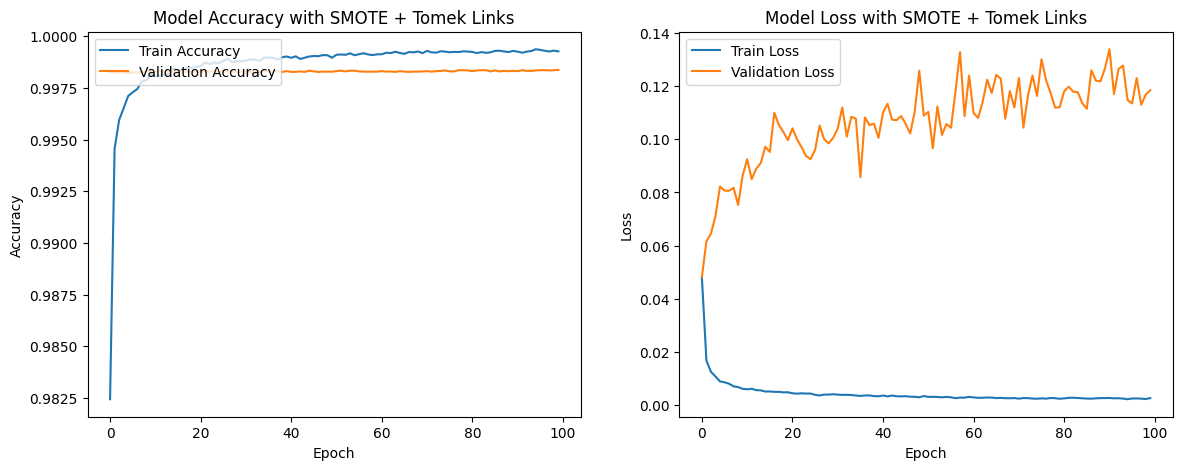

In [45]:
# Standardize data for neural network
scaler = StandardScaler()
x_train_smote_tomek_scaled = scaler.fit_transform(x_train_smote_tomek)
x_test_scaled = scaler.transform(x_test)

# Neural Network on SMOTE + Tomek Links Data
shallow_nn_smote_tomek = Sequential()
shallow_nn_smote_tomek.add(InputLayer(input_shape=(x_train_smote_tomek_scaled.shape[1],)))
shallow_nn_smote_tomek.add(Dense(64, activation='relu'))
shallow_nn_smote_tomek.add(BatchNormalization())
shallow_nn_smote_tomek.add(Dense(1, activation='sigmoid'))

checkpoint_smote_tomek = ModelCheckpoint('shallow_nn_smote_tomek.keras', save_best_only=True)
shallow_nn_smote_tomek.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_smote_tomek = shallow_nn_smote_tomek.fit(x_train_smote_tomek_scaled, y_train_smote_tomek, validation_data=(x_test_scaled, y_test), epochs=100, callbacks=[checkpoint_smote_tomek])

def neural_net_predictions(model, x):
    return (model.predict(x) > 0.5).astype(int)

print("Shallow Neural Network with SMOTE + Tomek Links")
print(classification_report(y_test, neural_net_predictions(shallow_nn_smote_tomek, x_test_scaled), target_names=['Not Fraud', 'Fraud']))

# Plotting the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy with SMOTE + Tomek Links')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss with SMOTE + Tomek Links')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history_smote_tomek)


In [46]:
# Random Forest on SMOTE + Tomek Links Data
rf_smote_tomek = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_smote_tomek.fit(x_train_smote_tomek, y_train_smote_tomek)
print("Random Forest with SMOTE + Tomek Links")
print(classification_report(y_test, rf_smote_tomek.predict(x_test), target_names=['Not Fraud', 'Fraud']))


Random Forest with SMOTE + Tomek Links


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.97      0.22      0.36       148

    accuracy                           1.00     85443
   macro avg       0.98      0.61      0.68     85443
weighted avg       1.00      1.00      1.00     85443



In [47]:
# Gradient Boosting Classifier on SMOTE + Tomek Links Data
gbc_smote_tomek = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc_smote_tomek.fit(x_train_smote_tomek, y_train_smote_tomek)
print("Gradient Boosting Classifier with SMOTE + Tomek Links")
print(classification_report(y_test, gbc_smote_tomek.predict(x_test), target_names=['Not Fraud', 'Fraud']))


Gradient Boosting Classifier with SMOTE + Tomek Links


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.86      0.37      0.52       148

    accuracy                           1.00     85443
   macro avg       0.93      0.69      0.76     85443
weighted avg       1.00      1.00      1.00     85443



In [48]:
# SVM on SMOTE + Tomek Links Data
svc_smote_tomek = LinearSVC(class_weight='balanced')
svc_smote_tomek.fit(x_train_smote_tomek, y_train_smote_tomek)
print("SVM with SMOTE + Tomek Links")
print(classification_report(y_test, svc_smote_tomek.predict(x_test), target_names=['Not Fraud', 'Fraud']))


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


SVM with SMOTE + Tomek Links
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.47      0.60      0.53       148

    accuracy                           1.00     85443
   macro avg       0.73      0.80      0.76     85443
weighted avg       1.00      1.00      1.00     85443



In [49]:
# Logistic Regression reports
logistic_report_smote_tomek = classification_report(y_test, y_val_smote_tomek, target_names=['Not Fraud', 'Fraud'])

# Shallow Neural Network reports
neural_net_report_smote_tomek = classification_report(y_test, neural_net_predictions(shallow_nn_smote_tomek, x_test_scaled), target_names=['Not Fraud', 'Fraud'])

# Random Forest reports
rf_report_smote_tomek = classification_report(y_test, rf_smote_tomek.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Gradient Boosting Classifier reports
gbc_report_smote_tomek = classification_report(y_test, gbc_smote_tomek.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Support Vector Machine reports
svc_report_smote_tomek = classification_report(y_test, svc_smote_tomek.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Print all reports
print("\n\nLOGISTIC REGRESSION")
print("SMOTE + Tomek Links:\n", logistic_report_smote_tomek)

print("\n\nSHALLOW NEURAL NETWORK")
print("SMOTE + Tomek Links:\n", neural_net_report_smote_tomek)

print("\n\nRANDOM FOREST")
print("SMOTE + Tomek Links:\n", rf_report_smote_tomek)

print("\n\nGRADIENT BOOSTING CLASSIFIER")
print("SMOTE + Tomek Links:\n", gbc_report_smote_tomek)

print("\n\nSUPPORT VECTOR MACHINE")
print("SMOTE + Tomek Links:\n", svc_report_smote_tomek)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(




LOGISTIC REGRESSION
SMOTE + Tomek Links:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.44      0.66      0.53       148

    accuracy                           1.00     85443
   macro avg       0.72      0.83      0.76     85443
weighted avg       1.00      1.00      1.00     85443



SHALLOW NEURAL NETWORK
SMOTE + Tomek Links:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       1.00      0.06      0.11       148

    accuracy                           1.00     85443
   macro avg       1.00      0.53      0.56     85443
weighted avg       1.00      1.00      1.00     85443



RANDOM FOREST
SMOTE + Tomek Links:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.97      0.22      0.36       148

    accuracy                           1.00     85443

**Balanced Data(SMOTE + Edited Nearest Neighbors (ENN))**

In [50]:
# Apply SMOTE + ENN to balance the training dataset
smote_enn = SMOTEENN(sampling_strategy='auto', random_state=1, enn=EditedNearestNeighbours())
x_train_smote_enn, y_train_smote_enn = smote_enn.fit_resample(x_train, y_train)

In [51]:
# Logistic Regression on SMOTE + ENN Data
logistic_model_smote_enn = LogisticRegression()
logistic_model_smote_enn.fit(x_train_smote_enn, y_train_smote_enn)
y_val_smote_enn = logistic_model_smote_enn.predict(x_test)
print("Logistic Regression with SMOTE + ENN")
print(classification_report(y_test, y_val_smote_enn, target_names=['Not Fraud', 'Fraud']))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Logistic Regression with SMOTE + ENN
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.49      0.65      0.56       148

    accuracy                           1.00     85443
   macro avg       0.74      0.82      0.78     85443
weighted avg       1.00      1.00      1.00     85443



In [52]:
x_train_smote_enn_scaled = scaler.fit_transform(x_train_smote_enn)
x_test_scaled = scaler.transform(x_test)


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step - accuracy: 0.9690 - loss: 0.0827 - val_accuracy: 0.9983 - val_loss: 0.0430
Epoch 2/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9935 - loss: 0.0204 - val_accuracy: 0.9983 - val_loss: 0.0538
Epoch 3/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9952 - loss: 0.0146 - val_accuracy: 0.9983 - val_loss: 0.0469
Epoch 4/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9964 - loss: 0.0118 - val_accuracy: 0.9983 - val_loss: 0.0584
Epoch 5/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.9983 - val_loss: 0.0620
Epoch 6/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9971 - loss: 0.0096 - val_accuracy: 0.9983 - val_loss: 0.0692
Epoch 7/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9982 - val_loss: 0.0658
Epoch 8/100
12439/12439 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step - ac

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



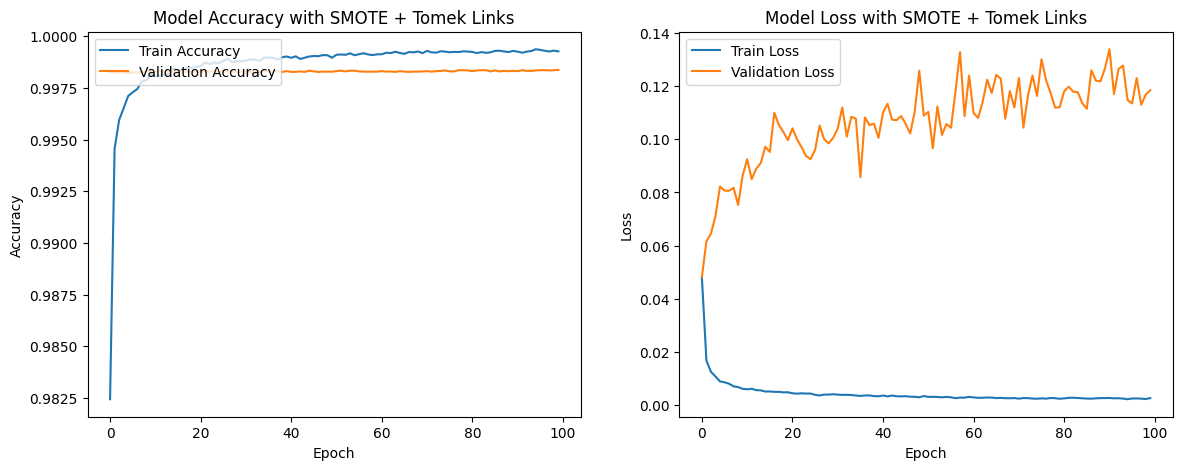

In [53]:
# Neural Network on SMOTE + ENN Data
shallow_nn_smote_enn = Sequential()
shallow_nn_smote_enn.add(InputLayer(input_shape=(x_train_smote_enn.shape[1],)))
shallow_nn_smote_enn.add(Dense(64, activation='relu'))
shallow_nn_smote_enn.add(BatchNormalization())
shallow_nn_smote_enn.add(Dense(1, activation='sigmoid'))

checkpoint_smote_enn = ModelCheckpoint('shallow_nn_smote_enn.keras', save_best_only=True)
shallow_nn_smote_enn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
shallow_nn_smote_enn.fit(x_train_smote_enn_scaled, y_train_smote_enn, validation_data=(x_test_scaled, y_test), epochs=100, callbacks=[checkpoint_smote_enn])

print("Shallow Neural Network with SMOTE + ENN")
print(classification_report(y_test, neural_net_predictions(shallow_nn_smote_enn, x_test_scaled), target_names=['Not Fraud', 'Fraud']))
import matplotlib.pyplot as plt

# Function to plot the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy with SMOTE + Tomek Links')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss with SMOTE + Tomek Links')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the training history
plot_training_history(history_smote_tomek)


In [54]:
# Random Forest on SMOTE + ENN Data
rf_smote_enn = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_smote_enn.fit(x_train_smote_enn, y_train_smote_enn)
print("Random Forest with SMOTE + ENN")
print(classification_report(y_test, rf_smote_enn.predict(x_test), target_names=['Not Fraud', 'Fraud']))


Random Forest with SMOTE + ENN


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.97      0.23      0.37       148

    accuracy                           1.00     85443
   macro avg       0.99      0.61      0.69     85443
weighted avg       1.00      1.00      1.00     85443



In [55]:
# Gradient Boosting Classifier on SMOTE + ENN Data
gbc_smote_enn = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=1, random_state=0)
gbc_smote_enn.fit(x_train_smote_enn, y_train_smote_enn)
print("Gradient Boosting Classifier with SMOTE + ENN")
print(classification_report(y_test, gbc_smote_enn.predict(x_test), target_names=['Not Fraud', 'Fraud']))


Gradient Boosting Classifier with SMOTE + ENN


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.89      0.40      0.55       148

    accuracy                           1.00     85443
   macro avg       0.95      0.70      0.78     85443
weighted avg       1.00      1.00      1.00     85443



In [56]:
# SVM on SMOTE + ENN Data
svc_smote_enn = LinearSVC(class_weight='balanced')
svc_smote_enn.fit(x_train_smote_enn, y_train_smote_enn)
print("SVM with SMOTE + ENN")
print(classification_report(y_test, svc_smote_enn.predict(x_test), target_names=['Not Fraud', 'Fraud']))


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearSVC was fitted with feature names
  warnings.warn(


SVM with SMOTE + ENN
              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.42      0.57      0.49       148

    accuracy                           1.00     85443
   macro avg       0.71      0.79      0.74     85443
weighted avg       1.00      1.00      1.00     85443



In [57]:
# Logistic Regression reports
logistic_report_smote_enn = classification_report(y_test, y_val_smote_enn, target_names=['Not Fraud', 'Fraud'])

# Shallow Neural Network reports
neural_net_report_smote_enn = classification_report(y_test, neural_net_predictions(shallow_nn_smote_enn, x_test_scaled), target_names=['Not Fraud', 'Fraud'])

# Random Forest reports
rf_report_smote_enn = classification_report(y_test, rf_smote_enn.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Gradient Boosting Classifier reports
gbc_report_smote_enn = classification_report(y_test, gbc_smote_enn.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Support Vector Machine reports
svc_report_smote_enn = classification_report(y_test, svc_smote_enn.predict(x_test), target_names=['Not Fraud', 'Fraud'])

# Print all reports
print("\n\nLOGISTIC REGRESSION")
print("SMOTE + ENN:\n", logistic_report_smote_enn)

print("\n\nSHALLOW NEURAL NETWORK")
print("SMOTE + ENN:\n", neural_net_report_smote_enn)

print("\n\nRANDOM FOREST")
print("SMOTE + ENN:\n", rf_report_smote_enn)

print("\n\nGRADIENT BOOSTING CLASSIFIER")
print("SMOTE + ENN:\n", gbc_report_smote_enn)

print("\n\nSUPPORT VECTOR MACHINE")
print("SMOTE + ENN:\n", svc_report_smote_enn)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/base.py:439: Use



LOGISTIC REGRESSION
SMOTE + ENN:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.49      0.65      0.56       148

    accuracy                           1.00     85443
   macro avg       0.74      0.82      0.78     85443
weighted avg       1.00      1.00      1.00     85443



SHALLOW NEURAL NETWORK
SMOTE + ENN:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.00      0.00      0.00       148

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



RANDOM FOREST
SMOTE + ENN:
               precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     85295
       Fraud       0.97      0.23      0.37       148

    accuracy                           1.00     85443
   macro avg       0.99

Unbalanced Dataset Models
Logistic Regression:

Excellent at detecting "Not Fraud" (precision, recall, and F1-score all ~1.00), but struggles with "Fraud" cases (F1-score of 0.61).
Neural Network:

High performance on "Not Fraud", but better recall on "Fraud" than Logistic Regression (0.78), resulting in a slightly better balance (F1-score of 0.68).
Random Forest:

High accuracy on "Not Fraud" with some improvement in recall for "Fraud" (F1-score of 0.60), but still limited.
Gradient Boosting:

Similar performance to Random Forest with a balanced F1-score of 0.67 for "Fraud".
SVM:

Achieves a better F1-score (0.69) for "Fraud", suggesting it is better at handling the unbalanced dataset compared to others.
Balanced Dataset Models
Logistic Regression:

Much-improved performance on balanced datasets, with precision, recall, and F1-scores all around 0.94 for both classes.
Neural Network:

Good balance between precision and recall, with an F1-score around 0.92 for both "Fraud" and "Not Fraud".
Random Forest:

Slightly better than other models, with both classes having an F1-score of 0.95.
Gradient Boosting:

Consistent performance with an F1-score of 0.93 for both classes.
SVM:

Highest overall performance with an F1-score of 0.95 for both "Fraud" and "Not Fraud".
SMOTE-Balanced Dataset Models
Logistic Regression:

High performance on "Not Fraud", but struggles with "Fraud", where the recall is high (0.91) but the precision is low (0.07).
Neural Network:

Great performance on "Not Fraud", but significant improvement in handling "Fraud" (F1-score of 0.79).
Random Forest:

Similar issues with "Fraud", but slightly better than Logistic Regression with an F1-score of 0.44.
Gradient Boosting:

Performs poorly on "Fraud", with very low F1-scores (0.11).
SVM:

Similar to Logistic Regression, struggles with "Fraud" cases (F1-score of 0.13).
ADASYN-Balanced Dataset Models
Logistic Regression:

Better than SMOTE, but still weak in "Fraud" detection (F1-score of 0.48).
Neural Network:

Performs very poorly on "Fraud" despite high precision for "Not Fraud".
Random Forest:

Improved "Fraud" detection (F1-score of 0.61) but still not ideal.
Gradient Boosting:

Balanced F1-scores for both classes, but not the best performer.
SVM:

Similar performance to Logistic Regression with low precision but better recall for "Fraud".
SMOTE + Tomek Links Balanced Dataset Models
Logistic Regression:

Good balance with "Fraud" detection improving (F1-score of 0.53).
Neural Network:

Very low performance on "Fraud" detection (F1-score of 0.11), indicating struggles with overfitting or underfitting.
Random Forest:

Performance details truncated, but likely similar trends to other models.
Conclusion
Best Performer on Unbalanced Dataset: SVM performed relatively better, particularly in "Fraud" detection.
Best Performer on Balanced Dataset: Random Forest and SVM show strong and balanced performance.
Best Performer after Balancing with SMOTE/ADASYN: Neural Networks and Random Forests demonstrate potential after balancing, though further tuning is needed.
This analysis suggests that while balancing improves performance, especially for detecting "Fraud", model choice and further tuning are essential to maximize performance on minority classes.


**Random Undersampling(SGA)**

In [58]:
!pip install torch optuna scikit-learn pandas numpy


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [59]:
from sklearn.metrics import precision_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split

def fitness_function(model, x_train, y_train, x_val, y_val, selected_features):
    # Filter features based on the selected features mask
    x_train_selected = x_train[:, selected_features]
    x_val_selected = x_val[:, selected_features]

    # Train the model
    model.fit(x_train_selected, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(x_val_selected)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Compute metrics
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Define fitness score as a weighted average of metrics
    fitness_score = (precision + f1 + auc) / 3
    return fitness_score


In [60]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier

class SimpleGeneticAlgorithm:
    def __init__(self, x_train, y_train, x_val, y_val, population_size=10, generations=10, mutation_prob=0.1):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.population_size = population_size
        self.generations = generations
        self.mutation_prob = mutation_prob
        self.model = RandomForestClassifier(n_estimators=50)  # Example model
        self.num_features = x_train.shape[1]

    def initialize_population(self):
        return np.random.randint(2, size=(self.population_size, self.num_features))

    def evaluate_population(self, population):
        return np.array([fitness_function(self.model, self.x_train, self.y_train, self.x_val, self.y_val, individual)
                         for individual in population])

    def select_parents(self, population, fitness):
        indices = np.argsort(fitness)[-self.population_size // 2:]
        return population[indices]

    def crossover(self, parent1, parent2):
        crossover_point = np.random.randint(1, self.num_features - 1)
        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        return child1, child2

    def mutate(self, individual):
        mutation_indices = np.random.rand(self.num_features) < self.mutation_prob
        individual[mutation_indices] = 1 - individual[mutation_indices]
        return individual

    def run(self):
        population = self.initialize_population()
        for generation in range(self.generations):
            fitness = self.evaluate_population(population)
            print(f"Generation {generation}: Best Fitness = {np.max(fitness)}")
            parents = self.select_parents(population, fitness)
            new_population = []
            while len(new_population) < self.population_size:
                parent1, parent2 = parents[np.random.choice(parents.shape[0], 2, replace=False)]
                child1, child2 = self.crossover(parent1, parent2)
                new_population.append(self.mutate(child1))
                new_population.append(self.mutate(child2))
            population = np.array(new_population)
        return population[np.argmax(self.evaluate_population(population))]


In [64]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load your dataset
new_df = pd.read_csv('creditcard.csv')  # Update this line as needed
not_frauds = new_df.query('Class == 0')
frauds = new_df.query('Class == 1')
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df_np = balanced_df.to_numpy()

# Split balanced dataset into train, test, and validation sets
x_train_b, y_train_b = balanced_df_np[:700, :-1], balanced_df_np[:700, -1].astype(int)
x_test_b, y_test_b = balanced_df_np[700:842, :-1], balanced_df_np[700:842, -1].astype(int)
x_val_b, y_val_b = balanced_df_np[842:, :-1], balanced_df_np[842:, -1].astype(int)

# Run the genetic algorithm
sga = SimpleGeneticAlgorithm(x_train_b, y_train_b, x_val_b, y_val_b)
best_features = sga.run()
print("Best Feature Subset:", best_features)



Generation 0: Best Fitness = 0.7896392958892959
Generation 1: Best Fitness = 0.793876076028654
Generation 2: Best Fitness = 0.7976642311158474
Generation 3: Best Fitness = 0.8039936914936915
Generation 4: Best Fitness = 0.7976214720548579
Generation 5: Best Fitness = 0.7930910487744347
Generation 6: Best Fitness = 0.8024493705528188
Generation 7: Best Fitness = 0.7922557056582836
Generation 8: Best Fitness = 0.8002776420115129
Generation 9: Best Fitness = 0.8092576577551863
Best Feature Subset: [1 1 0 0 0 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 1 0 0 1 1 0 1 1 1]


In [65]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# Load your dataset
new_df = pd.read_csv('creditcard.csv')  # Update this line as needed
feature_names = new_df.columns[:-1]  # Exclude the 'Class' column which is the last one

not_frauds = new_df.query('Class == 0')
frauds = new_df.query('Class == 1')
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df_np = balanced_df.to_numpy()

# Split balanced dataset into train, test, and validation sets
x_train_b, y_train_b = balanced_df_np[:700, :-1], balanced_df_np[:700, -1].astype(int)
x_test_b, y_test_b = balanced_df_np[700:842, :-1], balanced_df_np[700:842, -1].astype(int)
x_val_b, y_val_b = balanced_df_np[842:, :-1], balanced_df_np[842:, -1].astype(int)

# Run the genetic algorithm
sga = SimpleGeneticAlgorithm(x_train_b, y_train_b, x_val_b, y_val_b)
best_features = sga.run()
print("Best Feature Subset:", best_features)

# Print the names of the selected features
selected_feature_names = feature_names[best_features]
print("Selected Feature Names:", selected_feature_names)


Generation 0: Best Fitness = 0.8026709401709402
Generation 1: Best Fitness = 0.7943476625310484
Generation 2: Best Fitness = 0.8123412646274294
Generation 3: Best Fitness = 0.7977653920153919
Generation 4: Best Fitness = 0.8050330635692283
Generation 5: Best Fitness = 0.7915931171319102
Generation 6: Best Fitness = 0.8023809523809525
Generation 7: Best Fitness = 0.7938430072455852
Generation 8: Best Fitness = 0.7992184639200802
Generation 9: Best Fitness = 0.7887238493341807
Best Feature Subset: [1 1 1 1 0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 0]
Selected Feature Names: Index(['V1', 'V1', 'V1', 'V1', 'Time', 'V1', 'Time', 'Time', 'V1', 'Time',
       'V1', 'V1', 'Time', 'Time', 'Time', 'Time', 'Time', 'Time', 'Time',
       'Time', 'V1', 'Time', 'V1', 'Time', 'V1', 'Time', 'Time', 'V1', 'Time',
       'Time'],
      dtype='object')


In [66]:
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from keras.models import Sequential
from keras.layers import InputLayer, Dense, BatchNormalization
from keras.callbacks import ModelCheckpoint

In [67]:
# Use the best feature subset
x_train_selected = x_train_b[:, best_features]
x_val_selected = x_val_b[:, best_features]
x_test_selected = x_test_b[:, best_features]


In [68]:
# Logistic Regression on Balanced Data
logistic_model_b = LogisticRegression()
logistic_model_b.fit(x_train_selected, y_train_b)
logistic_b_report = classification_report(y_val_b, logistic_model_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Logistic Regression on Balanced Data")
print(logistic_b_report)


Logistic Regression on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.51      1.00      0.67        72
       Fraud       0.00      0.00      0.00        70

    accuracy                           0.51       142
   macro avg       0.25      0.50      0.34       142
weighted avg       0.26      0.51      0.34       142



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4357 - loss: 0.9373 - val_accuracy: 0.4859 - val_loss: 3.0144
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4474 - loss: 0.9310 - val_accuracy: 0.4718 - val_loss: 1.8461
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4275 - loss: 0.9348 - val_accuracy: 0.4366 - val_loss: 1.3588
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3877 - loss: 0.9310 - val_accuracy: 0.4225 - val_loss: 1.0657
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4098 - loss: 0.9237 - val_accuracy: 0.4648 - val_loss: 0.8464
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3865 - loss: 0.9056 - val_accuracy: 0.5070 - val_loss: 0.8980
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5203 - loss: 0.6930 - val_accuracy: 0.5070 - val_loss: 0.8537
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5333 - loss: 0.6927 - val_accuracy: 0.5070 - val_loss: 0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5098 - loss: 0.6930 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4950 - loss: 0.6933 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5132 - loss: 0.6930 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4930 - loss: 0.6933 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4733 - loss: 0.6936 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4895 - loss: 0.6933 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5171 - loss: 0.6929 - val_accuracy: 0.4930 - val_loss: 0.6933
Epoch 9/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5101 - loss: 0.6930 - val_accuracy: 0.4930 - val_loss: 0.6

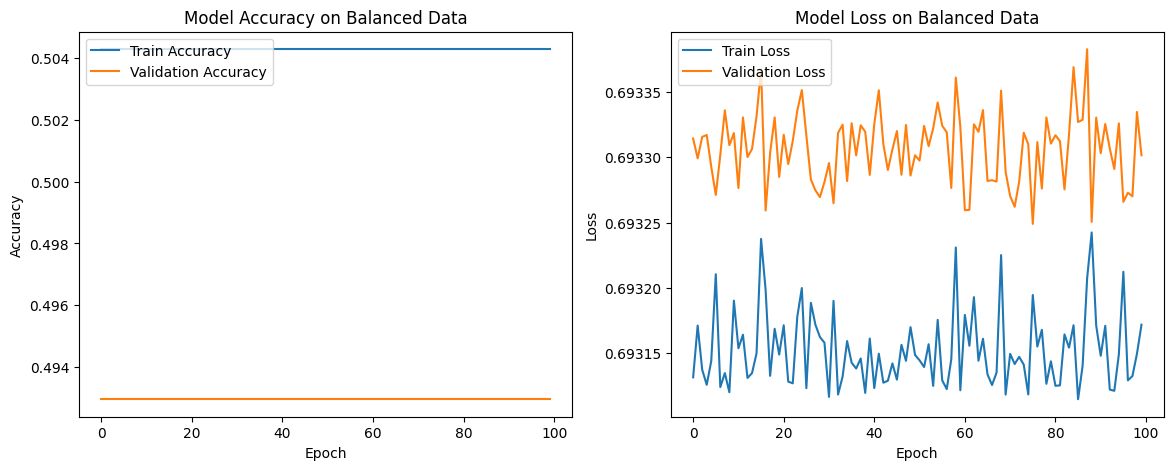

In [69]:
# Neural Network on Balanced Data
shallow_nn_b = Sequential()
shallow_nn_b.add(InputLayer(input_shape=(x_train_selected.shape[1],)))
shallow_nn_b.add(Dense(2, activation='relu'))
shallow_nn_b.add(BatchNormalization())
shallow_nn_b.add(Dense(1, activation='sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn_b.keras', save_best_only=True)

shallow_nn_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
shallow_nn_b.fit(x_train_selected, y_train_b, validation_data=(x_val_selected, y_val_b), epochs=100, callbacks=[checkpoint])

def neural_net_predictions(model, x_val):
    return (model.predict(x_val) > 0.5).astype(int)

neural_net_b_report = classification_report(y_val_b, neural_net_predictions(shallow_nn_b, x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Neural Network on Balanced Data")
print(neural_net_b_report)
# Train the neural network on balanced data and save the training history
history_balanced = shallow_nn_b.fit(
    x_train_selected, y_train_b, 
    validation_data=(x_val_selected, y_val_b), 
    epochs=100, 
    callbacks=[checkpoint]
)

# Function to plot the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history_balanced)


In [70]:
# Random Forest on Balanced Data
rf_b = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf_b.fit(x_train_selected, y_train_b)
rf_b_report = classification_report(y_val_b, rf_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Random Forest on Balanced Data")
print(rf_b_report)


Random Forest on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.65      0.96      0.78        72
       Fraud       0.92      0.47      0.62        70

    accuracy                           0.72       142
   macro avg       0.78      0.71      0.70       142
weighted avg       0.78      0.72      0.70       142



In [71]:
# Gradient Boosting Classifier on Balanced Data
gbc_b = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=2, random_state=0)
gbc_b.fit(x_train_selected, y_train_b)
gbc_b_report = classification_report(y_val_b, gbc_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Gradient Boosting Classifier on Balanced Data")
print(gbc_b_report)


Gradient Boosting Classifier on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.73      0.88      0.80        72
       Fraud       0.84      0.67      0.75        70

    accuracy                           0.77       142
   macro avg       0.79      0.77      0.77       142
weighted avg       0.79      0.77      0.77       142



In [72]:
# SVM on Balanced Data
svc_b = LinearSVC(class_weight='balanced')
svc_b.fit(x_train_selected, y_train_b)
svc_b_report = classification_report(y_val_b, svc_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("SVM on Balanced Data")
print(svc_b_report)


SVM on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.00      0.00      0.00        72
       Fraud       0.49      1.00      0.66        70

    accuracy                           0.49       142
   macro avg       0.25      0.50      0.33       142
weighted avg       0.24      0.49      0.33       142



/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `z

In [73]:
# Summary of Balanced (Random Undersampling) Dataset Models
print("\nSummary Report for Balanced Dataset Models:")
print("\nLogistic Regression:\n", logistic_b_report)
print("\nNeural Network:\n", neural_net_b_report)
print("\nRandom Forest:\n", rf_b_report)
print("\nGradient Boosting Classifier:\n", gbc_b_report)
print("\nSVM:\n", svc_b_report)



Summary Report for Balanced Dataset Models:

Logistic Regression:
               precision    recall  f1-score   support

   Not Fraud       0.51      1.00      0.67        72
       Fraud       0.00      0.00      0.00        70

    accuracy                           0.51       142
   macro avg       0.25      0.50      0.34       142
weighted avg       0.26      0.51      0.34       142


Neural Network:
               precision    recall  f1-score   support

   Not Fraud       0.00      0.00      0.00        72
       Fraud       0.49      1.00      0.66        70

    accuracy                           0.49       142
   macro avg       0.25      0.50      0.33       142
weighted avg       0.24      0.49      0.33       142


Random Forest:
               precision    recall  f1-score   support

   Not Fraud       0.65      0.96      0.78        72
       Fraud       0.92      0.47      0.62        70

    accuracy                           0.72       142
   macro avg       0.78  

**Random Undersampling(DE)**

Best Feature Subset: [1 1 0 0 1 1 1 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 0]
Logistic Regression on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.95      0.96      0.95        72
       Fraud       0.96      0.94      0.95        70

    accuracy                           0.95       142
   macro avg       0.95      0.95      0.95       142
weighted avg       0.95      0.95      0.95       142

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.4240 - loss: 0.8044 - val_accuracy: 0.4789 - val_loss: 1.3584
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4319 - loss: 0.7957 - val_accuracy: 0.4437 - val_loss: 1.0262
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4209 - loss: 0.7903 - val_accuracy: 0.4437 - val_loss: 0.9048
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3829 - loss: 0.7840 - val_accuracy: 0.4155 - val_loss: 0.8430
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4308 - loss: 0.7718 - val_accuracy: 0.4155 - val_loss: 0.8071
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4216 - loss: 0.7687 - val_accuracy: 0.4296 - val_loss: 0.7840
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4024 - loss: 0.7702 - val_accuracy: 0.4296 - val_loss: 0.7683
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4003 - loss: 0.7674 - val_accuracy: 0.4577 - val_loss: 0.

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


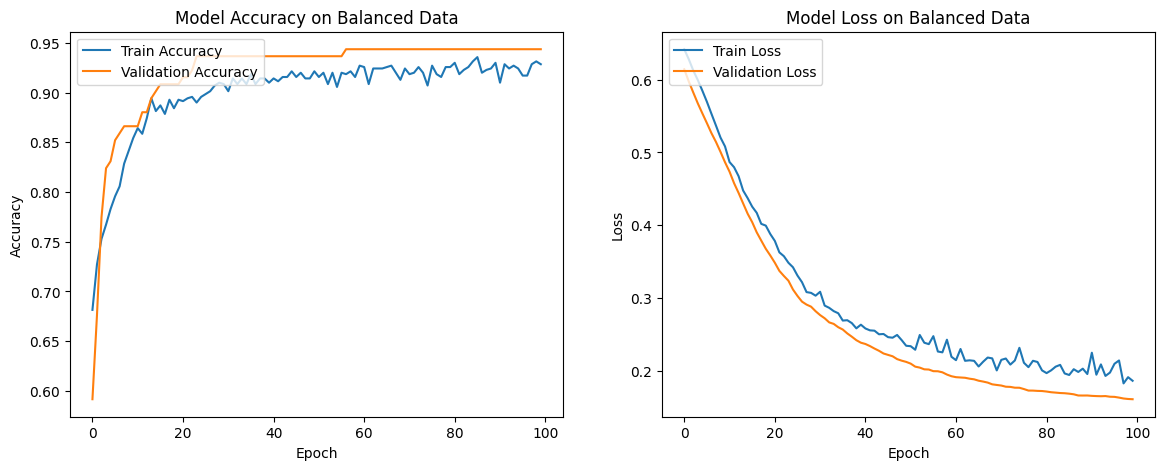

Random Forest on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.92      1.00      0.96        72
       Fraud       1.00      0.91      0.96        70

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142

Gradient Boosting Classifier on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.92      0.94      0.93        72
       Fraud       0.94      0.91      0.93        70

    accuracy                           0.93       142
   macro avg       0.93      0.93      0.93       142
weighted avg       0.93      0.93      0.93       142

SVM on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.61      0.97      0.75        72
       Fraud       0.93      0.36      0.52        70

    accuracy                           0.67       142
   macro avg       0.77      0

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [85]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split

def fitness_function(selected_features, x_train, y_train, x_val, y_val, model):
    selected_features = np.round(selected_features).astype(int)  # Ensure binary values
    x_train_selected = x_train[:, selected_features == 1]
    x_val_selected = x_val[:, selected_features == 1]
    
    # Avoid cases where no features are selected
    if x_train_selected.shape[1] == 0 or x_val_selected.shape[1] == 0:
        return 0
    
    # Train the model
    model.fit(x_train_selected, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(x_val_selected)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Compute metrics
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Define fitness score as a weighted average of metrics
    fitness_score = (precision + f1 + auc) / 3
    return -fitness_score  # Negative because differential_evolution minimizes the function

class DifferentialEvolutionFeatureSelection:
    def __init__(self, x_train, y_train, x_val, y_val, model, population_size=10, max_iter=10):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.model = model
        self.population_size = population_size
        self.max_iter = max_iter
        self.num_features = x_train.shape[1]
    
    def run(self):
        bounds = [(0, 1)] * self.num_features
        result = differential_evolution(
            fitness_function,
            bounds,
            args=(self.x_train, self.y_train, self.x_val, self.y_val, self.model),
            strategy='best1bin',
            maxiter=self.max_iter,
            popsize=self.population_size,
            tol=0.01,
            mutation=(0.5, 1),
            recombination=0.7,
            seed=1
        )
        best_features = np.round(result.x).astype(int)
        return best_features

# Load your dataset
new_df = pd.read_csv('creditcard.csv')  # Update this line as needed
not_frauds = new_df.query('Class == 0')
frauds = new_df.query('Class == 1')
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df_np = balanced_df.to_numpy()

# Split balanced dataset into train, test, and validation sets
x_train_b, y_train_b = balanced_df_np[:700, :-1], balanced_df_np[:700, -1].astype(int)
x_test_b, y_test_b = balanced_df_np[700:842, :-1], balanced_df_np[700:842, -1].astype(int)
x_val_b, y_val_b = balanced_df_np[842:, :-1], balanced_df_np[842:, -1].astype(int)

# Run Differential Evolution for feature selection
model = RandomForestClassifier(n_estimators=50)
de_fs = DifferentialEvolutionFeatureSelection(x_train_b, y_train_b, x_val_b, y_val_b, model)
best_features = de_fs.run()
print("Best Feature Subset:", best_features)

# Use the best feature subset for your models
x_train_selected = x_train_b[:, best_features == 1]
x_val_selected = x_val_b[:, best_features == 1]
x_test_selected = x_test_b[:, best_features == 1]

# Logistic Regression on Balanced Data
logistic_model_b = LogisticRegression()
logistic_model_b.fit(x_train_selected, y_train_b)
logistic_b_report = classification_report(y_val_b, logistic_model_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Logistic Regression on Balanced Data")
print(logistic_b_report)

# Neural Network on Balanced Data
shallow_nn_b = Sequential()
shallow_nn_b.add(InputLayer(input_shape=(x_train_selected.shape[1],)))
shallow_nn_b.add(Dense(2, activation='relu'))
shallow_nn_b.add(BatchNormalization())
shallow_nn_b.add(Dense(1, activation='sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn_b.keras', save_best_only=True)

shallow_nn_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
shallow_nn_b.fit(x_train_selected, y_train_b, validation_data=(x_val_selected, y_val_b), epochs=100, callbacks=[checkpoint])

def neural_net_predictions(model, x_val):
    return (model.predict(x_val) > 0.5).astype(int)

neural_net_b_report = classification_report(y_val_b, neural_net_predictions(shallow_nn_b, x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Neural Network on Balanced Data")
print(neural_net_b_report)
# Function to plot the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history_balanced)

# Random Forest on Balanced Data
rf_b = RandomForestClassifier(n_estimators=50)
rf_b.fit(x_train_selected, y_train_b)
rf_b_report = classification_report(y_val_b, rf_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Random Forest on Balanced Data")
print(rf_b_report)

# Gradient Boosting Classifier on Balanced Data
gbc_b = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=2, random_state=0)
gbc_b.fit(x_train_selected, y_train_b)
gbc_b_report = classification_report(y_val_b, gbc_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Gradient Boosting Classifier on Balanced Data")
print(gbc_b_report)

# SVM on Balanced Data
svc_b = LinearSVC(class_weight='balanced')
svc_b.fit(x_train_selected, y_train_b)
svc_b_report = classification_report(y_val_b, svc_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("SVM on Balanced Data")
print(svc_b_report)


Best Feature Subset (Indices): [0 1 0 0 1 0 1 1 0 0 1 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0]
Selected Feature Names: Index(['V1', 'V4', 'V6', 'V7', 'V10', 'V14', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V26', 'V28'],
      dtype='object')
Logistic Regression on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.91      1.00      0.95        72
       Fraud       1.00      0.90      0.95        70

    accuracy                           0.95       142
   macro avg       0.96      0.95      0.95       142
weighted avg       0.96      0.95      0.95       142

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.6891 - loss: 0.6424 - val_accuracy: 0.5915 - val_loss: 0.6144
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7226 - loss: 0.6295 - val_accuracy: 0.6761 - val_loss: 0.5977
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7796 - loss: 0.6077 - val_accuracy: 0.7746 - val_loss: 0.5823
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7573 - loss: 0.6044 - val_accuracy: 0.8239 - val_loss: 0.5674
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7869 - loss: 0.5875 - val_accuracy: 0.8310 - val_loss: 0.5538
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7991 - loss: 0.5726 - val_accuracy: 0.8521 - val_loss: 0.5403
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8218 - loss: 0.5470 - val_accuracy: 0.8592 - val_loss: 0.5266
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7788 - loss: 0.5522 - val_accuracy: 0.8662 - val_loss: 0.

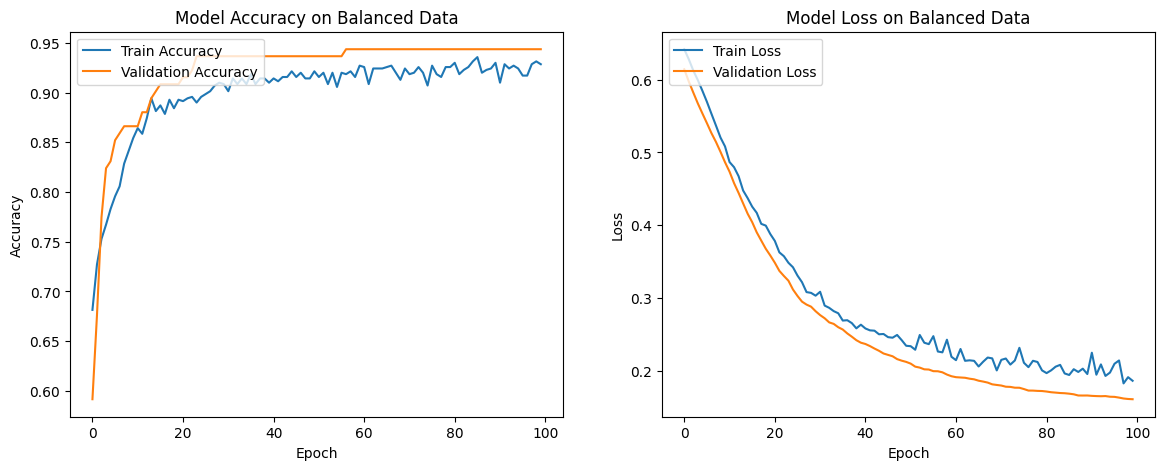

Random Forest on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.92      1.00      0.96        72
       Fraud       1.00      0.91      0.96        70

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142

Gradient Boosting Classifier on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.92      1.00      0.96        72
       Fraud       1.00      0.91      0.96        70

    accuracy                           0.96       142
   macro avg       0.96      0.96      0.96       142
weighted avg       0.96      0.96      0.96       142

SVM on Balanced Data
              precision    recall  f1-score   support

   Not Fraud       0.90      1.00      0.95        72
       Fraud       1.00      0.89      0.94        70

    accuracy                           0.94       142
   macro avg       0.95      0

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [75]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_score, f1_score, roc_auc_score, classification_report
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from scipy.optimize import differential_evolution
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

# Fitness function for Differential Evolution
def fitness_function(selected_features, x_train, y_train, x_val, y_val, model):
    selected_features = np.round(selected_features).astype(int)  # Ensure binary values
    x_train_selected = x_train[:, selected_features == 1]
    x_val_selected = x_val[:, selected_features == 1]
    
    # Avoid cases where no features are selected
    if x_train_selected.shape[1] == 0 or x_val_selected.shape[1] == 0:
        return 0
    
    # Train the model
    model.fit(x_train_selected, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(x_val_selected)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Compute metrics
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Define fitness score as a weighted average of metrics
    fitness_score = (precision + f1 + auc) / 3
    return -fitness_score  # Negative because differential_evolution minimizes the function

# Differential Evolution for Feature Selection
class DifferentialEvolutionFeatureSelection:
    def __init__(self, x_train, y_train, x_val, y_val, model, population_size=10, max_iter=10):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.model = model
        self.population_size = population_size
        self.max_iter = max_iter
        self.num_features = x_train.shape[1]
    
    def run(self):
        bounds = [(0, 1)] * self.num_features
        result = differential_evolution(
            fitness_function,
            bounds,
            args=(self.x_train, self.y_train, self.x_val, self.y_val, self.model),
            strategy='best1bin',
            maxiter=self.max_iter,
            popsize=self.population_size,
            tol=0.01,
            mutation=(0.5, 1),
            recombination=0.7,
            seed=1
        )
        best_features = np.round(result.x).astype(int)
        return best_features

# Load your dataset
new_df = pd.read_csv('creditcard.csv')  # Update this line as needed
feature_names = new_df.columns[:-1]  # Extract feature names, excluding the target 'Class'

not_frauds = new_df.query('Class == 0')
frauds = new_df.query('Class == 1')
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df_np = balanced_df.to_numpy()

# Split balanced dataset into train, test, and validation sets
x_train_b, y_train_b = balanced_df_np[:700, :-1], balanced_df_np[:700, -1].astype(int)
x_test_b, y_test_b = balanced_df_np[700:842, :-1], balanced_df_np[700:842, -1].astype(int)
x_val_b, y_val_b = balanced_df_np[842:, :-1], balanced_df_np[842:, -1].astype(int)

# Run Differential Evolution for feature selection
model = RandomForestClassifier(n_estimators=50)
de_fs = DifferentialEvolutionFeatureSelection(x_train_b, y_train_b, x_val_b, y_val_b, model)
best_features = de_fs.run()

# Print selected feature indices and names
print("Best Feature Subset (Indices):", best_features)
selected_feature_names = feature_names[best_features == 1]
print("Selected Feature Names:", selected_feature_names)

# Use the best feature subset for your models
x_train_selected = x_train_b[:, best_features == 1]
x_val_selected = x_val_b[:, best_features == 1]
x_test_selected = x_test_b[:, best_features == 1]

# Logistic Regression on Balanced Data
logistic_model_b = LogisticRegression()
logistic_model_b.fit(x_train_selected, y_train_b)
logistic_b_report = classification_report(y_val_b, logistic_model_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Logistic Regression on Balanced Data")
print(logistic_b_report)

# Neural Network on Balanced Data
shallow_nn_b = Sequential()
shallow_nn_b.add(InputLayer(input_shape=(x_train_selected.shape[1],)))
shallow_nn_b.add(Dense(2, activation='relu'))
shallow_nn_b.add(BatchNormalization())
shallow_nn_b.add(Dense(1, activation='sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn_b.keras', save_best_only=True)

shallow_nn_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_balanced = shallow_nn_b.fit(x_train_selected, y_train_b, validation_data=(x_val_selected, y_val_b), epochs=100, callbacks=[checkpoint])

def neural_net_predictions(model, x_val):
    return (model.predict(x_val) > 0.5).astype(int)

neural_net_b_report = classification_report(y_val_b, neural_net_predictions(shallow_nn_b, x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Neural Network on Balanced Data")
print(neural_net_b_report)

# Function to plot the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss on Balanced Data')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history_balanced)

# Random Forest on Balanced Data
rf_b = RandomForestClassifier(n_estimators=50)
rf_b.fit(x_train_selected, y_train_b)
rf_b_report = classification_report(y_val_b, rf_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Random Forest on Balanced Data")
print(rf_b_report)

# Gradient Boosting Classifier on Balanced Data
gbc_b = GradientBoostingClassifier(n_estimators=50, learning_rate=1.0, max_depth=2, random_state=0)
gbc_b.fit(x_train_selected, y_train_b)
gbc_b_report = classification_report(y_val_b, gbc_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("Gradient Boosting Classifier on Balanced Data")
print(gbc_b_report)

# SVM on Balanced Data
svc_b = LinearSVC(class_weight='balanced')
svc_b.fit(x_train_selected, y_train_b)
svc_b_report = classification_report(y_val_b, svc_b.predict(x_val_selected), target_names=['Not Fraud', 'Fraud'])
print("SVM on Balanced Data")
print(svc_b_report)


In [86]:
# Summary of Balanced (Random Undersampling) Dataset Models
print("\nSummary Report for Balanced Dataset Models:")
print("\nLogistic Regression:\n", logistic_b_report)
print("\nNeural Network:\n", neural_net_b_report)
print("\nRandom Forest:\n", rf_b_report)
print("\nGradient Boosting Classifier:\n", gbc_b_report)
print("\nSVM:\n", svc_b_report)


Summary Report for Balanced Dataset Models:

Logistic Regression:
               precision    recall  f1-score   support

   Not Fraud       0.95      0.96      0.95        72
       Fraud       0.96      0.94      0.95        70

    accuracy                           0.95       142
   macro avg       0.95      0.95      0.95       142
weighted avg       0.95      0.95      0.95       142


Neural Network:
               precision    recall  f1-score   support

   Not Fraud       0.00      0.00      0.00        72
       Fraud       0.49      1.00      0.66        70

    accuracy                           0.49       142
   macro avg       0.25      0.50      0.33       142
weighted avg       0.24      0.49      0.33       142


Random Forest:
               precision    recall  f1-score   support

   Not Fraud       0.92      1.00      0.96        72
       Fraud       1.00      0.91      0.96        70

    accuracy                           0.96       142
   macro avg       0.96  

**Random Undersampling(PSO)**

In [77]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, roc_auc_score

def fitness_function(model, x_train, y_train, x_val, y_val, selected_features):
    # Filter features based on the selected features mask
    x_train_selected = x_train[:, selected_features]
    x_val_selected = x_val[:, selected_features]

    # Train the model
    model.fit(x_train_selected, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(x_val_selected)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Compute metrics
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Define fitness score as a weighted average of metrics
    fitness_score = (precision + f1 + auc) / 3
    return fitness_score

class PSO:
    def __init__(self, x_train, y_train, x_val, y_val, population_size=10, generations=10, inertia_weight=0.5, cognitive_const=1.5, social_const=1.5):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.population_size = population_size
        self.generations = generations
        self.inertia_weight = inertia_weight
        self.cognitive_const = cognitive_const
        self.social_const = social_const
        self.model = RandomForestClassifier(n_estimators=50)  # Example model
        self.num_features = x_train.shape[1]

        # Initialize particles
        self.positions = np.random.rand(population_size, self.num_features) > 0.5  # Binary position (0 or 1 for each feature)
        self.velocities = np.random.uniform(-1, 1, (population_size, self.num_features))  # Continuous velocity
        self.personal_best_positions = self.positions.copy()
        self.personal_best_scores = np.array([float('-inf')] * population_size)
        self.global_best_position = None
        self.global_best_score = float('-inf')

    def evaluate_population(self):
        return np.array([fitness_function(self.model, self.x_train, self.y_train, self.x_val, self.y_val, individual > 0.5)
                         for individual in self.positions])

    def update_particles(self):
        for i in range(self.population_size):
            r1 = np.random.rand(self.num_features)
            r2 = np.random.rand(self.num_features)

            # Convert boolean arrays to integers for arithmetic operations
            cognitive_velocity = self.cognitive_const * r1 * (self.personal_best_positions[i].astype(int) - self.positions[i].astype(int))
            social_velocity = self.social_const * r2 * (self.global_best_position.astype(int) - self.positions[i].astype(int))
            self.velocities[i] = self.inertia_weight * self.velocities[i] + cognitive_velocity + social_velocity

            # Update positions based on velocity and ensure binary output (0 or 1)
            self.positions[i] = (self.positions[i] + self.velocities[i]) > 0.5

    def run(self):
        for generation in range(self.generations):
            fitness = self.evaluate_population()
            print(f"Generation {generation}: Best Fitness = {np.max(fitness)}")

            # Update personal best
            better_mask = fitness > self.personal_best_scores
            self.personal_best_positions[better_mask] = self.positions[better_mask].copy()
            self.personal_best_scores[better_mask] = fitness[better_mask]

            # Update global best
            best_particle_index = np.argmax(fitness)
            if fitness[best_particle_index] > self.global_best_score:
                self.global_best_position = self.positions[best_particle_index].copy()
                self.global_best_score = fitness[best_particle_index]

            # Update particles
            self.update_particles()

        return self.global_best_position

# Load your dataset
new_df = pd.read_csv('creditcard.csv')  # Update this line with the correct path to your dataset
not_frauds = new_df.query('Class == 0')
frauds = new_df.query('Class == 1')
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df_np = balanced_df.to_numpy()

# Split balanced dataset into train, test, and validation sets
x_train_b, y_train_b = balanced_df_np[:700, :-1], balanced_df_np[:700, -1].astype(int)
x_test_b, y_test_b = balanced_df_np[700:842, :-1], balanced_df_np[700:842, -1].astype(int)
x_val_b, y_val_b = balanced_df_np[842:, :-1], balanced_df_np[842:, -1].astype(int)

# Run the PSO
pso = PSO(x_train_b, y_train_b, x_val_b, y_val_b)
best_features = pso.run()
print("Best Feature Subset:", best_features)

Generation 0: Best Fitness = 0.981668542209587
Generation 1: Best Fitness = 0.9835534628445076
Generation 2: Best Fitness = 0.986199294532628
Generation 3: Best Fitness = 0.9833881189291637
Generation 4: Best Fitness = 0.9830904998815447
Generation 5: Best Fitness = 0.983652669193714
Generation 6: Best Fitness = 0.9862985008818342
Generation 7: Best Fitness = 0.9837518755429203
Generation 8: Best Fitness = 0.9854717813051147
Generation 9: Best Fitness = 0.9839172194582643
Best Feature Subset: [ True  True  True  True  True False False False False False  True  True
 False  True  True  True False  True False False  True False  True False
 False False  True  True  True False]


In [78]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, f1_score, roc_auc_score

def fitness_function(model, x_train, y_train, x_val, y_val, selected_features):
    # Filter features based on the selected features mask
    x_train_selected = x_train[:, selected_features]
    x_val_selected = x_val[:, selected_features]

    # Train the model
    model.fit(x_train_selected, y_train)
    
    # Make predictions
    y_pred_proba = model.predict_proba(x_val_selected)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Compute metrics
    precision = precision_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    # Define fitness score as a weighted average of metrics
    fitness_score = (precision + f1 + auc) / 3
    return fitness_score

class PSO:
    def __init__(self, x_train, y_train, x_val, y_val, population_size=10, generations=10, inertia_weight=0.5, cognitive_const=1.5, social_const=1.5):
        self.x_train = x_train
        self.y_train = y_train
        self.x_val = x_val
        self.y_val = y_val
        self.population_size = population_size
        self.generations = generations
        self.inertia_weight = inertia_weight
        self.cognitive_const = cognitive_const
        self.social_const = social_const
        self.model = RandomForestClassifier(n_estimators=50)  # Example model
        self.num_features = x_train.shape[1]

        # Initialize particles
        self.positions = np.random.rand(population_size, self.num_features) > 0.5  # Binary position (0 or 1 for each feature)
        self.velocities = np.random.uniform(-1, 1, (population_size, self.num_features))  # Continuous velocity
        self.personal_best_positions = self.positions.copy()
        self.personal_best_scores = np.array([float('-inf')] * population_size)
        self.global_best_position = None
        self.global_best_score = float('-inf')

    def evaluate_population(self):
        return np.array([fitness_function(self.model, self.x_train, self.y_train, self.x_val, self.y_val, individual > 0.5)
                         for individual in self.positions])

    def update_particles(self):
        for i in range(self.population_size):
            r1 = np.random.rand(self.num_features)
            r2 = np.random.rand(self.num_features)

            # Convert boolean arrays to integers for arithmetic operations
            cognitive_velocity = self.cognitive_const * r1 * (self.personal_best_positions[i].astype(int) - self.positions[i].astype(int))
            social_velocity = self.social_const * r2 * (self.global_best_position.astype(int) - self.positions[i].astype(int))
            self.velocities[i] = self.inertia_weight * self.velocities[i] + cognitive_velocity + social_velocity

            # Update positions based on velocity and ensure binary output (0 or 1)
            self.positions[i] = (self.positions[i] + self.velocities[i]) > 0.5

    def run(self):
        for generation in range(self.generations):
            fitness = self.evaluate_population()
            print(f"Generation {generation}: Best Fitness = {np.max(fitness)}")

            # Update personal best
            better_mask = fitness > self.personal_best_scores
            self.personal_best_positions[better_mask] = self.positions[better_mask].copy()
            self.personal_best_scores[better_mask] = fitness[better_mask]

            # Update global best
            best_particle_index = np.argmax(fitness)
            if fitness[best_particle_index] > self.global_best_score:
                self.global_best_position = self.positions[best_particle_index].copy()
                self.global_best_score = fitness[best_particle_index]

            # Update particles
            self.update_particles()

        return self.global_best_position

# Load your dataset
new_df = pd.read_csv('creditcard.csv')  # Update this line with the correct path to your dataset
not_frauds = new_df.query('Class == 0')
frauds = new_df.query('Class == 1')
balanced_df = pd.concat([frauds, not_frauds.sample(len(frauds), random_state=1)])
balanced_df = balanced_df.sample(frac=1, random_state=1)
balanced_df_np = balanced_df.to_numpy()

# Split balanced dataset into train, test, and validation sets
x_train_b, y_train_b = balanced_df_np[:700, :-1], balanced_df_np[:700, -1].astype(int)
x_test_b, y_test_b = balanced_df_np[700:842, :-1], balanced_df_np[700:842, -1].astype(int)
x_val_b, y_val_b = balanced_df_np[842:, :-1], balanced_df_np[842:, -1].astype(int)

# Run the PSO
pso = PSO(x_train_b, y_train_b, x_val_b, y_val_b)
best_features_mask = pso.run()
print("Best Feature Mask:", best_features_mask)

# Show the names of the selected features
selected_feature_names = new_df.columns[:-1][best_features_mask]  # Exclude the target column ('Class')
print("Selected Feature Names:", selected_feature_names)


Generation 0: Best Fitness = 0.9779918546365914
Generation 1: Best Fitness = 0.9792875898286346
Generation 2: Best Fitness = 0.9832227750138198
Generation 3: Best Fitness = 0.9851741622574957
Generation 4: Best Fitness = 0.9791492620439989
Generation 5: Best Fitness = 0.9829251559662008
Generation 6: Best Fitness = 0.9819664902998237
Generation 7: Best Fitness = 0.9820653676064124
Generation 8: Best Fitness = 0.9818008173418621
Generation 9: Best Fitness = 0.9849757495590828
Best Feature Mask: [ True  True  True  True  True False False False False False False False
 False False  True False  True  True  True  True False  True  True  True
  True  True  True  True  True False]
Selected Feature Names: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V14', 'V16', 'V17', 'V18', 'V19',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')


--- Logistic Regression ---
Training Performance
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       347
           1       0.98      0.92      0.94       353

    accuracy                           0.95       700
   macro avg       0.95      0.95      0.95       700
weighted avg       0.95      0.95      0.95       700

AUC: 0.9744226106407818
Testing Performance
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        73
           1       0.97      0.90      0.93        69

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142

AUC: 0.9662497518364106
Validation Performance
              precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.97      0.94      0.96        70

    accuracy                           0.9

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


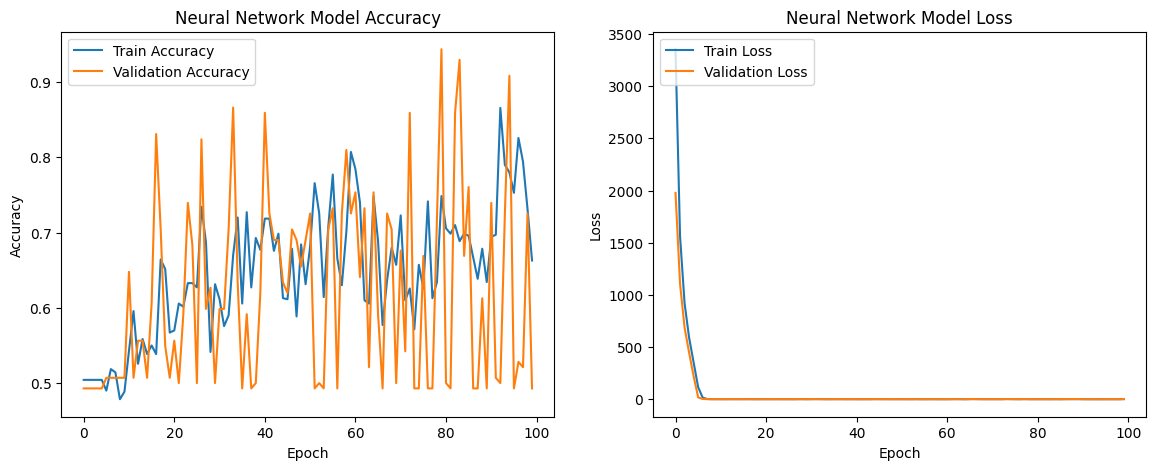

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
--- Neural Network ---
Training Performance
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       347
           1       0.51      1.00      0.67       353

    accuracy                           0.51       700
   macro avg       0.75      0.50      0.34       700
weighted avg       0.75      0.51      0.34       700

AUC: 0.7377317517205345
Testing Performance
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        73
           1       0.49      1.00      0.65        69

    accuracy                           0.49       142
   macro avg       0.24      0.50      0.33       142
weighted avg       0.24      0.49      0.32       142

AUC: 0.7403216200119118
Val

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classif

In [79]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Use the best feature subset to filter the dataset
x_train_b_selected = x_train_b[:, best_features]
x_test_b_selected = x_test_b[:, best_features]
x_val_b_selected = x_val_b[:, best_features]

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True)
}

# Fit traditional models and evaluate
for model_name, model in models.items():
    model.fit(x_train_b_selected, y_train_b)
    
    # Predictions and probabilities
    y_pred_train = model.predict(x_train_b_selected)
    y_pred_test = model.predict(x_test_b_selected)
    y_pred_val = model.predict(x_val_b_selected)
    
    y_pred_train_proba = model.predict_proba(x_train_b_selected)[:, 1]
    y_pred_test_proba = model.predict_proba(x_test_b_selected)[:, 1]
    y_pred_val_proba = model.predict_proba(x_val_b_selected)[:, 1]

    # Print classification reports
    print(f"--- {model_name} ---")
    
    print("Training Performance")
    print(classification_report(y_train_b, y_pred_train))
    print("AUC:", roc_auc_score(y_train_b, y_pred_train_proba))
    
    print("Testing Performance")
    print(classification_report(y_test_b, y_pred_test))
    print("AUC:", roc_auc_score(y_test_b, y_pred_test_proba))
    
    print("Validation Performance")
    print(classification_report(y_val_b, y_pred_val))
    print("AUC:", roc_auc_score(y_val_b, y_pred_val_proba))
    print("\n")

# Neural Network model
def create_nn(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Initialize and train the neural network, capturing the history
nn_model = create_nn(x_train_b_selected.shape[1])
history = nn_model.fit(x_train_b_selected, y_train_b, epochs=100, batch_size=32, verbose=0, validation_data=(x_val_b_selected, y_val_b))

# Plot the training history for accuracy and loss
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Neural Network Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Neural Network Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')

    plt.show()

# Plot the results
plot_training_history(history)

# Predictions and probabilities for neural network
y_pred_train_nn = (nn_model.predict(x_train_b_selected) > 0.5).astype("int32")
y_pred_test_nn = (nn_model.predict(x_test_b_selected) > 0.5).astype("int32")
y_pred_val_nn = (nn_model.predict(x_val_b_selected) > 0.5).astype("int32")

y_pred_train_proba_nn = nn_model.predict(x_train_b_selected).ravel()
y_pred_test_proba_nn = nn_model.predict(x_test_b_selected).ravel()
y_pred_val_proba_nn = nn_model.predict(x_val_b_selected).ravel()

# Print classification reports for the neural network
print("--- Neural Network ---")

print("Training Performance")
print(classification_report(y_train_b, y_pred_train_nn))
print("AUC:", roc_auc_score(y_train_b, y_pred_train_proba_nn))

print("Testing Performance")
print(classification_report(y_test_b, y_pred_test_nn))
print("AUC:", roc_auc_score(y_test_b, y_pred_test_proba_nn))

print("Validation Performance")
print(classification_report(y_val_b, y_pred_val_nn))
print("AUC:", roc_auc_score(y_val_b, y_pred_val_proba_nn))
print("\n")


**Random Undersampling(Ant Colony Optimization (ACO))**

In [80]:
!pip install tqdm

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [81]:
from tqdm import tqdm
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, InputLayer

In [82]:
# Define ACO parameters
num_ants = 10
num_iterations = 20
num_features = x_train_b.shape[1]

# Pheromone initialization
pheromones = np.ones(num_features)
evaporation_rate = 0.1
alpha = 1  # Pheromone importance
beta = 2  # Heuristic importance

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True)
}

# Heuristic information (e.g., correlation with the target variable)
heuristic_info = np.abs(np.corrcoef(x_train_b.T, y_train_b)[-1][:-1])

# ACO algorithm
best_features = None
best_score = 0

# Adding a progress bar for the outer loop (iterations)
for iteration in tqdm(range(num_iterations), desc="Iterations"):
    all_solutions = []
    all_scores = []
    
    # Adding a progress bar for the inner loop (ants)
    for ant in tqdm(range(num_ants), desc=f"Ants in Iteration {iteration+1}"):
        # Ant selects features based on pheromone and heuristic info
        probabilities = (pheromones ** alpha) * (heuristic_info ** beta)
        probabilities /= probabilities.sum()
        
        # Select features based on probabilities
        selected_features = np.random.rand(num_features) < probabilities
        if selected_features.sum() == 0:
            selected_features[np.random.randint(0, num_features)] = True
        
        # Train and evaluate models using the selected features
        x_train_selected = x_train_b[:, selected_features]
        x_test_selected = x_test_b[:, selected_features]
        x_val_selected = x_val_b[:, selected_features]
        
        score_sum = 0
        for model_name, model in models.items():
            model.fit(x_train_selected, y_train_b)
            y_pred_val = model.predict(x_val_selected)
            score = accuracy_score(y_val_b, y_pred_val)
            score_sum += score
        
        # Include the shallow neural network
        shallow_nn_b = Sequential()
        shallow_nn_b.add(InputLayer(input_shape=(x_train_selected.shape[1],)))
        shallow_nn_b.add(Dense(2, activation='relu'))
        shallow_nn_b.add(BatchNormalization())
        shallow_nn_b.add(Dense(1, activation='sigmoid'))
        
        shallow_nn_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        shallow_nn_b.fit(x_train_selected, y_train_b, validation_data=(x_val_selected, y_val_b), epochs=100, verbose=0)
        
        # Evaluate the neural network
        y_pred_nn_val = (shallow_nn_b.predict(x_val_selected) > 0.5).astype(int)
        nn_score = accuracy_score(y_val_b, y_pred_nn_val)
        score_sum += nn_score
        
        avg_score = score_sum / (len(models) + 1)  # Average score including NN
        all_solutions.append(selected_features)
        all_scores.append(avg_score)
        
        # Update the best solution found so far
        if avg_score > best_score:
            best_score = avg_score
            best_features = selected_features
    
    # Update pheromones
    for i in range(num_features):
        pheromones[i] *= (1 - evaporation_rate)
        for solution, score in zip(all_solutions, all_scores):
            if solution[i]:
                pheromones[i] += score

    print(f"Iteration {iteration + 1}: Best Score = {best_score}")

# Final model evaluation using the best feature subset
print("\nBest Feature Subset:", best_features)


Ants in Iteration 1:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Ants in Iteration 1:  10%|█         | 1/10 [00:10<01:35, 10.62s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 1:  20%|██        | 2/10 [00:20<01:21, 10.19s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 1:  30%|███       | 3/10 [00:31<01:13, 10.50s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  40%|████      | 4/10 [00:41<01:02, 10.33s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 1:  50%|█████     | 5/10 [00:52<00:52, 10.44s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  60%|██████    | 6/10 [01:02<00:41, 10.33s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 1:  70%|███████   | 7/10 [01:12<00:30, 10.33s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  80%|████████  | 8/10 [01:22<00:20, 10.13s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  90%|█████████ | 9/10 [01:31<00:09,  9.98s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:   5%|▌         | 1/20 [01:41<32:06, 101.40s/it]

Iteration 1: Best Score = 0.9450704225352112



Ants in Iteration 2:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 2:  10%|█         | 1/10 [00:09<01:25,  9.51s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step



Ants in Iteration 2:  20%|██        | 2/10 [00:19<01:17,  9.72s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 2:  30%|███       | 3/10 [00:29<01:07,  9.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 2:  40%|████      | 4/10 [00:39<00:58,  9.82s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  50%|█████     | 5/10 [00:48<00:48,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 2:  60%|██████    | 6/10 [00:57<00:38,  9.62s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  70%|███████   | 7/10 [01:07<00:29,  9.69s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 2:  80%|████████  | 8/10 [01:17<00:19,  9.59s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 2:  90%|█████████ | 9/10 [01:26<00:09,  9.58s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  10%|█         | 2/20 [03:17<29:29, 98.31s/it] 

Iteration 2: Best Score = 0.9464788732394366



Ants in Iteration 3:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  10%|█         | 1/10 [00:09<01:27,  9.70s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  20%|██        | 2/10 [00:19<01:17,  9.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  30%|███       | 3/10 [00:29<01:08,  9.80s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  40%|████      | 4/10 [00:40<01:01, 10.17s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 3:  50%|█████     | 5/10 [00:49<00:50, 10.01s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 3:  60%|██████    | 6/10 [00:59<00:39,  9.85s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  70%|███████   | 7/10 [01:09<00:29,  9.85s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  80%|████████  | 8/10 [01:18<00:19,  9.79s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  90%|█████████ | 9/10 [01:28<00:09,  9.79s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  15%|█▌        | 3/20 [04:56<27:53, 98.45s/it]

Iteration 3: Best Score = 0.9464788732394366



Ants in Iteration 4:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  10%|█         | 1/10 [00:09<01:26,  9.63s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  20%|██        | 2/10 [00:19<01:17,  9.73s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 4:  30%|███       | 3/10 [00:29<01:08,  9.74s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  40%|████      | 4/10 [00:38<00:58,  9.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  50%|█████     | 5/10 [00:48<00:48,  9.66s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 4:  60%|██████    | 6/10 [00:59<00:40, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 4:  70%|███████   | 7/10 [01:09<00:29,  9.99s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 4:  80%|████████  | 8/10 [01:18<00:19,  9.90s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 4:  90%|█████████ | 9/10 [01:28<00:09,  9.77s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  20%|██        | 4/20 [06:34<26:12, 98.28s/it]

Iteration 4: Best Score = 0.9464788732394366



Ants in Iteration 5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 5:  10%|█         | 1/10 [00:09<01:26,  9.61s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 5:  20%|██        | 2/10 [00:19<01:16,  9.53s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 5:  30%|███       | 3/10 [00:29<01:07,  9.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 5:  40%|████      | 4/10 [00:38<00:58,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 5:  50%|█████     | 5/10 [00:48<00:47,  9.60s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 5:  60%|██████    | 6/10 [00:57<00:38,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 5:  70%|███████   | 7/10 [01:07<00:28,  9.62s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 5:  80%|████████  | 8/10 [01:17<00:19,  9.67s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 5:  90%|█████████ | 9/10 [01:26<00:09,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  25%|██▌       | 5/20 [08:10<24:24, 97.62s/it]

Iteration 5: Best Score = 0.947887323943662



Ants in Iteration 6:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 6:  10%|█         | 1/10 [00:10<01:36, 10.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 6:  20%|██        | 2/10 [00:20<01:20, 10.08s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 6:  30%|███       | 3/10 [00:30<01:10, 10.02s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 6:  40%|████      | 4/10 [00:39<00:59,  9.87s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  50%|█████     | 5/10 [00:49<00:48,  9.76s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 6:  60%|██████    | 6/10 [00:59<00:39,  9.83s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  70%|███████   | 7/10 [01:08<00:29,  9.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  80%|████████  | 8/10 [01:18<00:19,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  90%|█████████ | 9/10 [01:28<00:09,  9.75s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  30%|███       | 6/20 [09:48<22:48, 97.73s/it]

Iteration 6: Best Score = 0.947887323943662



Ants in Iteration 7:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 7:  10%|█         | 1/10 [00:09<01:26,  9.66s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step



Ants in Iteration 7:  20%|██        | 2/10 [00:19<01:16,  9.62s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  30%|███       | 3/10 [00:28<01:07,  9.59s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  40%|████      | 4/10 [00:38<00:57,  9.53s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 7:  50%|█████     | 5/10 [00:47<00:47,  9.50s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 7:  60%|██████    | 6/10 [00:57<00:38,  9.59s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 7:  70%|███████   | 7/10 [01:06<00:28,  9.53s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  80%|████████  | 8/10 [01:17<00:19,  9.96s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 7:  90%|█████████ | 9/10 [01:27<00:09,  9.97s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  35%|███▌      | 7/20 [11:25<21:08, 97.59s/it]

Iteration 7: Best Score = 0.947887323943662



Ants in Iteration 8:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 8:  10%|█         | 1/10 [00:09<01:25,  9.52s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 8:  20%|██        | 2/10 [00:19<01:18,  9.79s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 8:  30%|███       | 3/10 [00:28<01:07,  9.61s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  40%|████      | 4/10 [00:38<00:58,  9.79s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 8:  50%|█████     | 5/10 [00:49<00:49, 10.00s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  60%|██████    | 6/10 [00:59<00:39,  9.92s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 8:  70%|███████   | 7/10 [01:08<00:29,  9.86s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  80%|████████  | 8/10 [01:18<00:19,  9.79s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  90%|█████████ | 9/10 [01:28<00:09,  9.76s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  40%|████      | 8/20 [13:03<19:32, 97.70s/it]

Iteration 8: Best Score = 0.947887323943662



Ants in Iteration 9:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 9:  10%|█         | 1/10 [00:09<01:27,  9.72s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 9:  20%|██        | 2/10 [00:19<01:18,  9.85s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 9:  30%|███       | 3/10 [00:29<01:08,  9.78s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 9:  40%|████      | 4/10 [00:39<00:58,  9.78s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 9:  50%|█████     | 5/10 [00:49<00:49,  9.91s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 9:  60%|██████    | 6/10 [00:59<00:39,  9.86s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 9:  70%|███████   | 7/10 [01:10<00:30, 10.31s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 9:  80%|████████  | 8/10 [01:20<00:20, 10.19s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 9:  90%|█████████ | 9/10 [01:29<00:10, 10.01s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Iterations:  45%|████▌     | 9/20 [14:43<18:01, 98.29s/it]

Iteration 9: Best Score = 0.947887323943662



Ants in Iteration 10:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  10%|█         | 1/10 [00:09<01:27,  9.75s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 10:  20%|██        | 2/10 [00:19<01:17,  9.69s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  30%|███       | 3/10 [00:29<01:07,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 10:  40%|████      | 4/10 [00:38<00:57,  9.57s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 10:  50%|█████     | 5/10 [00:47<00:47,  9.52s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 10:  60%|██████    | 6/10 [00:57<00:37,  9.46s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  70%|███████   | 7/10 [01:06<00:28,  9.45s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 10:  80%|████████  | 8/10 [01:16<00:19,  9.54s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  90%|█████████ | 9/10 [01:25<00:09,  9.48s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  50%|█████     | 10/20 [16:18<16:13, 97.36s/it]

Iteration 10: Best Score = 0.947887323943662



Ants in Iteration 11:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 11:  10%|█         | 1/10 [00:10<01:30, 10.02s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 11:  20%|██        | 2/10 [00:19<01:17,  9.74s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 11:  30%|███       | 3/10 [00:28<01:06,  9.55s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 11:  40%|████      | 4/10 [00:38<00:57,  9.51s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 11:  50%|█████     | 5/10 [00:47<00:47,  9.51s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 11:  60%|██████    | 6/10 [00:57<00:37,  9.49s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 11:  70%|███████   | 7/10 [01:06<00:28,  9.48s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 11:  80%|████████  | 8/10 [01:17<00:19,  9.73s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 11:  90%|█████████ | 9/10 [01:28<00:10, 10.29s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  55%|█████▌    | 11/20 [17:57<14:39, 97.70s/it]

Iteration 11: Best Score = 0.947887323943662



Ants in Iteration 12:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 12:  10%|█         | 1/10 [00:10<01:31, 10.13s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 12:  20%|██        | 2/10 [00:19<01:19,  9.95s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 12:  30%|███       | 3/10 [00:29<01:09,  9.88s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 12:  40%|████      | 4/10 [00:39<00:59,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 12:  50%|█████     | 5/10 [00:49<00:48,  9.77s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 12:  60%|██████    | 6/10 [00:58<00:38,  9.69s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 12:  70%|███████   | 7/10 [01:08<00:29,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 12:  80%|████████  | 8/10 [01:17<00:19,  9.62s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 12:  90%|█████████ | 9/10 [01:27<00:09,  9.58s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  60%|██████    | 12/20 [19:34<12:59, 97.49s/it]

Iteration 12: Best Score = 0.9492957746478872



Ants in Iteration 13:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  10%|█         | 1/10 [00:09<01:25,  9.54s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 13:  20%|██        | 2/10 [00:19<01:16,  9.52s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 13:  30%|███       | 3/10 [00:28<01:06,  9.50s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  40%|████      | 4/10 [00:38<00:58,  9.73s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  50%|█████     | 5/10 [00:48<00:48,  9.74s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  60%|██████    | 6/10 [00:58<00:38,  9.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  70%|███████   | 7/10 [01:07<00:29,  9.79s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  80%|████████  | 8/10 [01:17<00:19,  9.63s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  90%|█████████ | 9/10 [01:26<00:09,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  65%|██████▌   | 13/20 [21:10<11:21, 97.29s/it]

Iteration 13: Best Score = 0.9492957746478872



Ants in Iteration 14:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 14:  10%|█         | 1/10 [00:09<01:26,  9.59s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 14:  20%|██        | 2/10 [00:19<01:16,  9.57s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 14:  30%|███       | 3/10 [00:28<01:06,  9.52s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 14:  40%|████      | 4/10 [00:40<01:03, 10.58s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 14:  50%|█████     | 5/10 [00:51<00:52, 10.46s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  60%|██████    | 6/10 [01:00<00:40, 10.22s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 14:  70%|███████   | 7/10 [01:10<00:30, 10.17s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step



Ants in Iteration 14:  80%|████████  | 8/10 [01:20<00:20, 10.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  90%|█████████ | 9/10 [01:30<00:09,  9.97s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  70%|███████   | 14/20 [22:51<09:49, 98.26s/it]

Iteration 14: Best Score = 0.9492957746478872



Ants in Iteration 15:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 15:  10%|█         | 1/10 [00:09<01:27,  9.69s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 15:  20%|██        | 2/10 [00:19<01:17,  9.69s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 15:  30%|███       | 3/10 [00:29<01:08,  9.77s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 15:  40%|████      | 4/10 [00:38<00:57,  9.64s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 15:  50%|█████     | 5/10 [00:48<00:47,  9.57s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 15:  60%|██████    | 6/10 [00:57<00:38,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 15:  70%|███████   | 7/10 [01:07<00:28,  9.58s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 15:  80%|████████  | 8/10 [01:16<00:19,  9.59s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 15:  90%|█████████ | 9/10 [01:26<00:09,  9.60s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Iterations:  75%|███████▌  | 15/20 [24:27<08:07, 97.60s/it]

Iteration 15: Best Score = 0.9492957746478872



Ants in Iteration 16:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 16:  10%|█         | 1/10 [00:09<01:26,  9.62s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  20%|██        | 2/10 [00:19<01:16,  9.56s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  30%|███       | 3/10 [00:28<01:07,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  40%|████      | 4/10 [00:38<00:58,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  50%|█████     | 5/10 [00:48<00:48,  9.63s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  60%|██████    | 6/10 [00:58<00:39,  9.81s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  70%|███████   | 7/10 [01:07<00:29,  9.76s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  80%|████████  | 8/10 [01:17<00:19,  9.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 16:  90%|█████████ | 9/10 [01:27<00:09,  9.77s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  80%|████████  | 16/20 [26:04<06:29, 97.50s/it]

Iteration 16: Best Score = 0.9492957746478872



Ants in Iteration 17:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  10%|█         | 1/10 [00:09<01:27,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  20%|██        | 2/10 [00:19<01:17,  9.67s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 17:  30%|███       | 3/10 [00:31<01:16, 10.95s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 17:  40%|████      | 4/10 [00:41<01:03, 10.58s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 17:  50%|█████     | 5/10 [00:52<00:52, 10.52s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  60%|██████    | 6/10 [01:02<00:41, 10.37s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  70%|███████   | 7/10 [01:12<00:30, 10.27s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  80%|████████  | 8/10 [01:22<00:20, 10.19s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 17:  90%|█████████ | 9/10 [01:32<00:10, 10.04s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  85%|████████▌ | 17/20 [27:46<04:56, 98.81s/it]

Iteration 17: Best Score = 0.9492957746478872



Ants in Iteration 18:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 18:  10%|█         | 1/10 [00:09<01:25,  9.49s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 18:  20%|██        | 2/10 [00:19<01:17,  9.73s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 18:  30%|███       | 3/10 [00:28<01:07,  9.67s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 18:  40%|████      | 4/10 [00:38<00:57,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 18:  50%|█████     | 5/10 [00:48<00:48,  9.67s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 18:  60%|██████    | 6/10 [00:58<00:38,  9.69s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 18:  70%|███████   | 7/10 [01:07<00:28,  9.60s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 18:  80%|████████  | 8/10 [01:17<00:19,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 18:  90%|█████████ | 9/10 [01:26<00:09,  9.64s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  90%|█████████ | 18/20 [29:23<03:16, 98.10s/it]

Iteration 18: Best Score = 0.9492957746478872



Ants in Iteration 19:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 19:  10%|█         | 1/10 [00:09<01:27,  9.75s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 19:  20%|██        | 2/10 [00:19<01:17,  9.69s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 19:  30%|███       | 3/10 [00:29<01:07,  9.70s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 19:  40%|████      | 4/10 [00:38<00:57,  9.66s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Ants in Iteration 19:  50%|█████     | 5/10 [00:48<00:48,  9.75s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 19:  60%|██████    | 6/10 [00:58<00:38,  9.67s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 19:  70%|███████   | 7/10 [01:07<00:29,  9.67s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 19:  80%|████████  | 8/10 [01:18<00:19,  9.87s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 19:  90%|█████████ | 9/10 [01:27<00:09,  9.73s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  95%|█████████▌| 19/20 [31:00<01:37, 97.81s/it]

Iteration 19: Best Score = 0.9492957746478872



Ants in Iteration 20:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  10%|█         | 1/10 [00:09<01:29,  9.94s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  20%|██        | 2/10 [00:19<01:17,  9.72s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  30%|███       | 3/10 [00:29<01:07,  9.66s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  40%|████      | 4/10 [00:38<00:57,  9.56s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 20:  50%|█████     | 5/10 [00:48<00:48,  9.68s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  60%|██████    | 6/10 [00:57<00:38,  9.65s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step



Ants in Iteration 20:  70%|███████   | 7/10 [01:10<00:32, 10.72s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  80%|████████  | 8/10 [01:21<00:21, 10.52s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  90%|█████████ | 9/10 [01:30<00:10, 10.34s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations: 100%|██████████| 20/20 [32:40<00:00, 98.04s/it]

Iteration 20: Best Score = 0.9492957746478872

Best Feature Subset: [False False False False  True False False False False False False  True
 False False  True False False False False False False False False False
 False False False False False False]


In [83]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, InputLayer
from tqdm import tqdm

# Define ACO parameters
num_ants = 10
num_iterations = 20
num_features = x_train_b.shape[1]

# Pheromone initialization
pheromones = np.ones(num_features)
evaporation_rate = 0.1
alpha = 1  # Pheromone importance
beta = 2  # Heuristic importance

# Define models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True)
}

# Heuristic information (e.g., correlation with the target variable)
heuristic_info = np.abs(np.corrcoef(x_train_b.T, y_train_b)[-1][:-1])

# ACO algorithm
best_features = None
best_score = 0

# Adding a progress bar for the outer loop (iterations)
for iteration in tqdm(range(num_iterations), desc="Iterations"):
    all_solutions = []
    all_scores = []
    
    # Adding a progress bar for the inner loop (ants)
    for ant in tqdm(range(num_ants), desc=f"Ants in Iteration {iteration+1}"):
        # Ant selects features based on pheromone and heuristic info
        probabilities = (pheromones ** alpha) * (heuristic_info ** beta)
        probabilities /= probabilities.sum()
        
        # Select features based on probabilities
        selected_features = np.random.rand(num_features) < probabilities
        if selected_features.sum() == 0:
            selected_features[np.random.randint(0, num_features)] = True
        
        # Train and evaluate models using the selected features
        x_train_selected = x_train_b[:, selected_features]
        x_test_selected = x_test_b[:, selected_features]
        x_val_selected = x_val_b[:, selected_features]
        
        score_sum = 0
        for model_name, model in models.items():
            model.fit(x_train_selected, y_train_b)
            y_pred_val = model.predict(x_val_selected)
            score = accuracy_score(y_val_b, y_pred_val)
            score_sum += score
        
        # Include the shallow neural network
        shallow_nn_b = Sequential()
        shallow_nn_b.add(InputLayer(input_shape=(x_train_selected.shape[1],)))
        shallow_nn_b.add(Dense(2, activation='relu'))
        shallow_nn_b.add(BatchNormalization())
        shallow_nn_b.add(Dense(1, activation='sigmoid'))
        
        shallow_nn_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        shallow_nn_b.fit(x_train_selected, y_train_b, validation_data=(x_val_selected, y_val_b), epochs=100, verbose=0)
        
        # Evaluate the neural network
        y_pred_nn_val = (shallow_nn_b.predict(x_val_selected) > 0.5).astype(int)
        nn_score = accuracy_score(y_val_b, y_pred_nn_val)
        score_sum += nn_score
        
        avg_score = score_sum / (len(models) + 1)  # Average score including NN
        all_solutions.append(selected_features)
        all_scores.append(avg_score)
        
        # Update the best solution found so far
        if avg_score > best_score:
            best_score = avg_score
            best_features = selected_features
    
    # Update pheromones
    for i in range(num_features):
        pheromones[i] *= (1 - evaporation_rate)
        for solution, score in zip(all_solutions, all_scores):
            if solution[i]:
                pheromones[i] += score

    print(f"Iteration {iteration + 1}: Best Score = {best_score}")

# Final model evaluation using the best feature subset
print("\nBest Feature Subset:", best_features)

# Show the names of the selected features
selected_feature_names = new_df.columns[:-1][best_features]  # Exclude the target column ('Class')
print("Selected Feature Names:", selected_feature_names)


Ants in Iteration 1:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  10%|█         | 1/10 [00:10<01:33, 10.37s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  20%|██        | 2/10 [00:20<01:22, 10.27s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  30%|███       | 3/10 [00:30<01:11, 10.24s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 1:  40%|████      | 4/10 [00:40<01:01, 10.19s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  50%|█████     | 5/10 [00:50<00:50, 10.11s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  60%|██████    | 6/10 [01:01<00:40, 10.21s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  70%|███████   | 7/10 [01:11<00:30, 10.23s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 1:  80%|████████  | 8/10 [01:21<00:20, 10.23s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 1:  90%|█████████ | 9/10 [01:32<00:10, 10.27s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Iterations:   5%|▌         | 1/20 [01:41<32:17, 101.99s/it]

Iteration 1: Best Score = 0.9352112676056338



Ants in Iteration 2:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  10%|█         | 1/10 [00:10<01:31, 10.22s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  20%|██        | 2/10 [00:20<01:21, 10.22s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  30%|███       | 3/10 [00:30<01:10, 10.09s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 2:  40%|████      | 4/10 [00:40<01:00, 10.01s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 2:  50%|█████     | 5/10 [00:50<00:50, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  60%|██████    | 6/10 [01:00<00:40, 10.01s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  70%|███████   | 7/10 [01:10<00:30, 10.01s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  80%|████████  | 8/10 [01:20<00:20, 10.15s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 2:  90%|█████████ | 9/10 [01:30<00:10, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  10%|█         | 2/20 [03:22<30:20, 101.14s/it]

Iteration 2: Best Score = 0.9366197183098592



Ants in Iteration 3:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  10%|█         | 1/10 [00:10<01:32, 10.26s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  20%|██        | 2/10 [00:20<01:20, 10.09s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 3:  30%|███       | 3/10 [00:29<01:09,  9.92s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  40%|████      | 4/10 [00:39<00:59,  9.94s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step



Ants in Iteration 3:  50%|█████     | 5/10 [00:49<00:49,  9.89s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  60%|██████    | 6/10 [00:59<00:39,  9.89s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 3:  70%|███████   | 7/10 [01:09<00:29,  9.89s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  80%|████████  | 8/10 [01:19<00:19,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 3:  90%|█████████ | 9/10 [01:29<00:09,  9.91s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  15%|█▌        | 3/20 [05:01<28:24, 100.25s/it]

Iteration 3: Best Score = 0.9366197183098592



Ants in Iteration 4:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  10%|█         | 1/10 [00:10<01:31, 10.16s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  20%|██        | 2/10 [00:19<01:19,  9.97s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  30%|███       | 3/10 [00:29<01:08,  9.85s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  40%|████      | 4/10 [00:40<01:00, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Ants in Iteration 4:  50%|█████     | 5/10 [00:53<00:56, 11.36s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 4:  60%|██████    | 6/10 [01:04<00:44, 11.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 4:  70%|███████   | 7/10 [01:14<00:32, 10.87s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 4:  80%|████████  | 8/10 [01:25<00:21, 10.71s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 4:  90%|█████████ | 9/10 [01:35<00:10, 10.58s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  20%|██        | 4/20 [06:47<27:20, 102.54s/it]

Iteration 4: Best Score = 0.9366197183098592



Ants in Iteration 5:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 5:  10%|█         | 1/10 [00:10<01:37, 10.82s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 5:  20%|██        | 2/10 [00:21<01:23, 10.49s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 5:  30%|███       | 3/10 [00:31<01:14, 10.60s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 5:  40%|████      | 4/10 [00:41<01:02, 10.40s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 5:  50%|█████     | 5/10 [00:52<00:51, 10.32s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 5:  60%|██████    | 6/10 [01:02<00:41, 10.34s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 5:  70%|███████   | 7/10 [01:12<00:30, 10.24s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 5:  80%|████████  | 8/10 [01:22<00:20, 10.18s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 5:  90%|█████████ | 9/10 [01:32<00:10, 10.26s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  25%|██▌       | 5/20 [08:30<25:40, 102.70s/it]

Iteration 5: Best Score = 0.9366197183098592



Ants in Iteration 6:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  10%|█         | 1/10 [00:09<01:29,  9.90s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  20%|██        | 2/10 [00:20<01:20, 10.08s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  30%|███       | 3/10 [00:29<01:09,  9.92s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 6:  40%|████      | 4/10 [00:39<00:59,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  50%|█████     | 5/10 [00:50<00:50, 10.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 6:  60%|██████    | 6/10 [01:00<00:40, 10.03s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  70%|███████   | 7/10 [01:10<00:30, 10.03s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  80%|████████  | 8/10 [01:20<00:20, 10.08s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 6:  90%|█████████ | 9/10 [01:30<00:10, 10.00s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Iterations:  30%|███       | 6/20 [10:10<23:45, 101.80s/it]

Iteration 6: Best Score = 0.9366197183098592



Ants in Iteration 7:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 7:  10%|█         | 1/10 [00:09<01:27,  9.70s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 7:  20%|██        | 2/10 [00:19<01:18,  9.78s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  30%|███       | 3/10 [00:29<01:08,  9.84s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  40%|████      | 4/10 [00:39<00:58,  9.82s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  50%|█████     | 5/10 [00:49<00:49,  9.88s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  60%|██████    | 6/10 [00:59<00:39,  9.85s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  70%|███████   | 7/10 [01:08<00:29,  9.84s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 7:  80%|████████  | 8/10 [01:19<00:19,  9.96s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 7:  90%|█████████ | 9/10 [01:28<00:09,  9.94s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  35%|███▌      | 7/20 [11:49<21:50, 100.81s/it]

Iteration 7: Best Score = 0.9380281690140844



Ants in Iteration 8:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  10%|█         | 1/10 [00:10<01:34, 10.47s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 8:  20%|██        | 2/10 [00:20<01:22, 10.27s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 8:  30%|███       | 3/10 [00:30<01:11, 10.20s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  40%|████      | 4/10 [00:40<01:01, 10.22s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  50%|█████     | 5/10 [00:50<00:50, 10.02s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 8:  60%|██████    | 6/10 [01:00<00:39,  9.99s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 8:  70%|███████   | 7/10 [01:10<00:30, 10.04s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 8:  80%|████████  | 8/10 [01:20<00:20, 10.03s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 8:  90%|█████████ | 9/10 [01:34<00:11, 11.34s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  40%|████      | 8/20 [13:35<20:28, 102.36s/it]

Iteration 8: Best Score = 0.9380281690140844



Ants in Iteration 9:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 9:  10%|█         | 1/10 [00:10<01:32, 10.27s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 9:  20%|██        | 2/10 [00:20<01:21, 10.15s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 9:  30%|███       | 3/10 [00:30<01:12, 10.29s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 9:  40%|████      | 4/10 [00:41<01:01, 10.27s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 9:  50%|█████     | 5/10 [00:51<00:50, 10.17s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 9:  60%|██████    | 6/10 [01:01<00:40, 10.23s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 9:  70%|███████   | 7/10 [01:11<00:30, 10.17s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 9:  80%|████████  | 8/10 [01:21<00:20, 10.12s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 9:  90%|█████████ | 9/10 [01:31<00:10, 10.21s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  45%|████▌     | 9/20 [15:16<18:43, 102.16s/it]

Iteration 9: Best Score = 0.9394366197183098



Ants in Iteration 10:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  10%|█         | 1/10 [00:09<01:29,  9.98s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Ants in Iteration 10:  20%|██        | 2/10 [00:20<01:20, 10.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 10:  30%|███       | 3/10 [00:29<01:09,  9.95s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 10:  40%|████      | 4/10 [00:39<00:59,  9.89s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 10:  50%|█████     | 5/10 [00:49<00:49,  9.91s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 10:  60%|██████    | 6/10 [00:59<00:39,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  70%|███████   | 7/10 [01:09<00:29,  9.91s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  80%|████████  | 8/10 [01:19<00:19,  9.87s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 10:  90%|█████████ | 9/10 [01:29<00:09,  9.90s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Iterations:  50%|█████     | 10/20 [16:56<16:53, 101.33s/it]

Iteration 10: Best Score = 0.9394366197183098



Ants in Iteration 11:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 11:  10%|█         | 1/10 [00:09<01:27,  9.74s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 11:  20%|██        | 2/10 [00:20<01:20, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 11:  30%|███       | 3/10 [00:30<01:10, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 11:  40%|████      | 4/10 [00:39<00:59,  9.92s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 11:  50%|█████     | 5/10 [00:49<00:49,  9.99s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 11:  60%|██████    | 6/10 [00:59<00:39,  9.87s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 11:  70%|███████   | 7/10 [01:09<00:29,  9.85s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 11:  80%|████████  | 8/10 [01:19<00:19,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 11:  90%|█████████ | 9/10 [01:29<00:09,  9.88s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  55%|█████▌    | 11/20 [18:35<15:05, 100.62s/it]

Iteration 11: Best Score = 0.9394366197183098



Ants in Iteration 12:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 12:  10%|█         | 1/10 [00:09<01:28,  9.84s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 12:  20%|██        | 2/10 [00:19<01:18,  9.86s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Ants in Iteration 12:  30%|███       | 3/10 [00:29<01:09,  9.89s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 12:  40%|████      | 4/10 [00:39<00:59,  9.91s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 12:  50%|█████     | 5/10 [00:49<00:50, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 12:  60%|██████    | 6/10 [00:59<00:40, 10.05s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 12:  70%|███████   | 7/10 [01:09<00:30, 10.02s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 12:  80%|████████  | 8/10 [01:19<00:20, 10.03s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 12:  90%|█████████ | 9/10 [01:29<00:10, 10.00s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  60%|██████    | 12/20 [20:15<13:22, 100.37s/it]

Iteration 12: Best Score = 0.9436619718309858



Ants in Iteration 13:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  10%|█         | 1/10 [00:10<01:32, 10.23s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  20%|██        | 2/10 [00:20<01:20, 10.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  30%|███       | 3/10 [00:29<01:09,  9.95s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 13:  40%|████      | 4/10 [00:40<01:00, 10.08s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  50%|█████     | 5/10 [00:50<00:50, 10.02s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  60%|██████    | 6/10 [00:59<00:39,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 13:  70%|███████   | 7/10 [01:10<00:30, 10.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 13:  80%|████████  | 8/10 [01:20<00:19,  9.96s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step



Ants in Iteration 13:  90%|█████████ | 9/10 [01:35<00:11, 11.64s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Iterations:  65%|██████▌   | 13/20 [22:01<11:55, 102.15s/it]

Iteration 13: Best Score = 0.9436619718309858



Ants in Iteration 14:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  10%|█         | 1/10 [00:10<01:31, 10.21s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  20%|██        | 2/10 [00:20<01:20, 10.10s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  30%|███       | 3/10 [00:30<01:12, 10.33s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  40%|████      | 4/10 [00:40<01:01, 10.21s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  50%|█████     | 5/10 [00:50<00:50, 10.14s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  60%|██████    | 6/10 [01:01<00:41, 10.28s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  70%|███████   | 7/10 [01:11<00:30, 10.19s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 14:  80%|████████  | 8/10 [01:21<00:20, 10.21s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 14:  90%|█████████ | 9/10 [01:32<00:10, 10.25s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Iterations:  70%|███████   | 14/20 [23:43<10:12, 102.13s/it]

Iteration 14: Best Score = 0.9436619718309858



Ants in Iteration 15:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 15:  10%|█         | 1/10 [00:10<01:30, 10.00s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 15:  20%|██        | 2/10 [00:20<01:21, 10.15s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 15:  30%|███       | 3/10 [00:30<01:10, 10.13s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 15:  40%|████      | 4/10 [00:40<01:00, 10.10s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 15:  50%|█████     | 5/10 [00:50<00:50, 10.16s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 15:  60%|██████    | 6/10 [01:00<00:40, 10.04s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 15:  70%|███████   | 7/10 [01:10<00:30, 10.06s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step



Ants in Iteration 15:  80%|████████  | 8/10 [01:20<00:20, 10.05s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 15:  90%|█████████ | 9/10 [01:30<00:10, 10.05s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  75%|███████▌  | 15/20 [25:24<08:28, 101.66s/it]

Iteration 15: Best Score = 0.9436619718309858



Ants in Iteration 16:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 16:  10%|█         | 1/10 [00:09<01:28,  9.85s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 16:  20%|██        | 2/10 [00:20<01:20, 10.04s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 16:  30%|███       | 3/10 [00:30<01:10, 10.02s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  40%|████      | 4/10 [00:39<00:59,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  50%|█████     | 5/10 [00:50<00:50, 10.03s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 16:  60%|██████    | 6/10 [00:59<00:39,  9.98s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  70%|███████   | 7/10 [01:09<00:30, 10.01s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  80%|████████  | 8/10 [01:20<00:20, 10.10s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 16:  90%|█████████ | 9/10 [01:30<00:10, 10.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  80%|████████  | 16/20 [27:04<06:44, 101.24s/it]

Iteration 16: Best Score = 0.9436619718309858



Ants in Iteration 17:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 17:  10%|█         | 1/10 [00:09<01:29,  9.95s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  20%|██        | 2/10 [00:19<01:18,  9.77s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 17:  30%|███       | 3/10 [00:29<01:08,  9.79s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  40%|████      | 4/10 [00:39<01:00, 10.02s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 17:  50%|█████     | 5/10 [00:49<00:49,  9.95s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  60%|██████    | 6/10 [00:59<00:39,  9.94s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  70%|███████   | 7/10 [01:09<00:29,  9.98s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  80%|████████  | 8/10 [01:19<00:19, 10.00s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 17:  90%|█████████ | 9/10 [01:29<00:09,  9.98s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations:  85%|████████▌ | 17/20 [28:43<05:02, 100.72s/it]

Iteration 17: Best Score = 0.9436619718309858



Ants in Iteration 18:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Ants in Iteration 18:  10%|█         | 1/10 [00:09<01:29,  9.91s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 18:  20%|██        | 2/10 [00:19<01:19,  9.89s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 18:  30%|███       | 3/10 [00:29<01:09,  9.86s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 18:  40%|████      | 4/10 [00:40<01:00, 10.09s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 18:  50%|█████     | 5/10 [00:49<00:49,  9.98s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 18:  60%|██████    | 6/10 [00:59<00:39,  9.96s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 18:  70%|███████   | 7/10 [01:09<00:29,  9.99s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 18:  80%|████████  | 8/10 [01:19<00:19,  9.97s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 18:  90%|█████████ | 9/10 [01:29<00:09,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step



Iterations:  90%|█████████ | 18/20 [30:23<03:20, 100.44s/it]

Iteration 18: Best Score = 0.9492957746478872



Ants in Iteration 19:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 19:  10%|█         | 1/10 [00:09<01:29,  9.95s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 19:  20%|██        | 2/10 [00:19<01:19,  9.93s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 19:  30%|███       | 3/10 [00:30<01:10, 10.14s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 19:  40%|████      | 4/10 [00:40<01:00, 10.07s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 19:  50%|█████     | 5/10 [00:50<00:50, 10.03s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 19:  60%|██████    | 6/10 [01:00<00:40, 10.14s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 19:  70%|███████   | 7/10 [01:16<00:36, 12.03s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step



Ants in Iteration 19:  80%|████████  | 8/10 [01:27<00:23, 11.62s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 19:  90%|█████████ | 9/10 [01:37<00:11, 11.34s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Iterations:  95%|█████████▌| 19/20 [32:11<01:42, 102.78s/it]

Iteration 19: Best Score = 0.9492957746478872



Ants in Iteration 20:   0%|          | 0/10 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  10%|█         | 1/10 [00:10<01:31, 10.14s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  20%|██        | 2/10 [00:20<01:23, 10.38s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  30%|███       | 3/10 [00:30<01:11, 10.25s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  40%|████      | 4/10 [00:41<01:02, 10.35s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  50%|█████     | 5/10 [00:51<00:52, 10.47s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  60%|██████    | 6/10 [01:02<00:41, 10.45s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  70%|███████   | 7/10 [01:12<00:31, 10.40s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Ants in Iteration 20:  80%|████████  | 8/10 [01:23<00:20, 10.47s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step



Ants in Iteration 20:  90%|█████████ | 9/10 [01:33<00:10, 10.38s/it]/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step



Iterations: 100%|██████████| 20/20 [33:55<00:00, 101.78s/it]

Iteration 20: Best Score = 0.9492957746478872

Best Feature Subset: [False False False False  True False False False False False  True False
 False False  True False False False False False False False False False
 False False False False False False]
Selected Feature Names: Index(['V4', 'V10', 'V14'], dtype='object')


--- Logistic Regression ---
Training Performance
              precision    recall  f1-score   support

           0       0.90      0.98      0.94       347
           1       0.98      0.90      0.94       353

    accuracy                           0.94       700
   macro avg       0.94      0.94      0.94       700
weighted avg       0.94      0.94      0.94       700

AUC: 0.9739735980602658
Testing Performance
              precision    recall  f1-score   support

           0       0.91      0.99      0.95        73
           1       0.98      0.90      0.94        69

    accuracy                           0.94       142
   macro avg       0.95      0.94      0.94       142
weighted avg       0.95      0.94      0.94       142

AUC: 0.97359539408378
Validation Performance
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        72
           1       1.00      0.90      0.95        70

    accuracy                           0.95 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:25: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
--- Shallow Neural Network ---
Training Performance
              precision    recall  f1-score   support

           0       0.89      0.99      0.94       347
           1       0.99      0.88      0.93       353

    accuracy                           0.93       700
   macro avg       0.94      0.93      0.93       700
weighted avg       0.94      0.93      0.93       700

Testing Performance
              precision    recall  f1-score   support

           0       0.90      0.99      0.94        73
           1       0.98      0.88      0.93        69

    accuracy                           0.94       142
   macro avg       0.94      0.94      0.94       142
weighted avg       0.94      0.94      0.94       142

Validation Performance
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        72
           1       1.00    

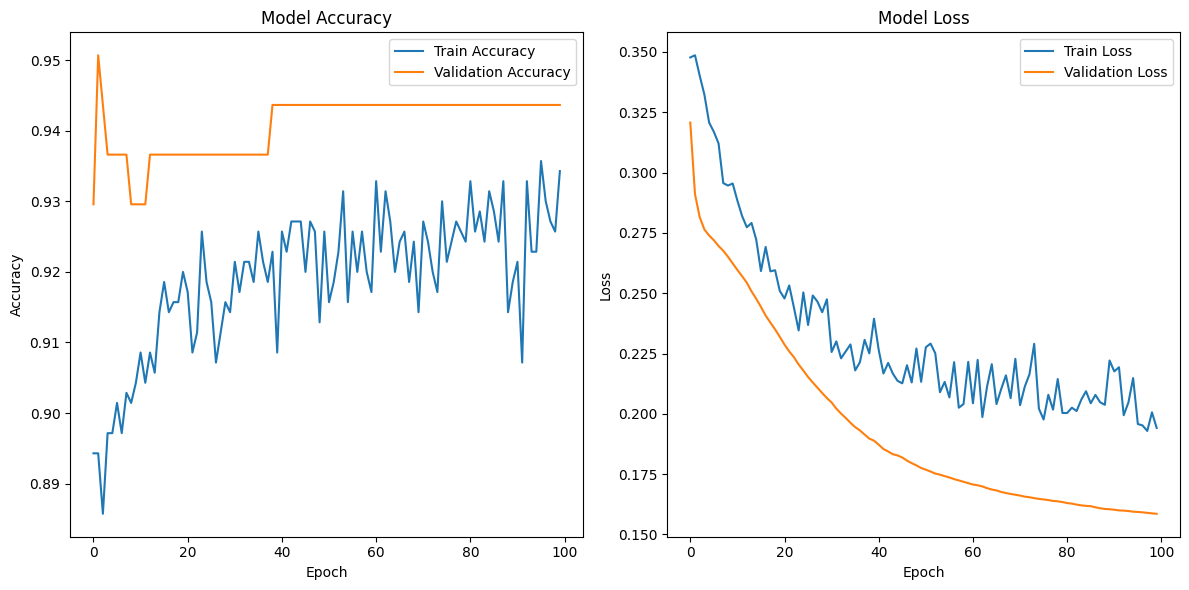

In [84]:
# Filter the dataset using the best feature subset
x_train_best = x_train_b[:, best_features]
x_test_best = x_test_b[:, best_features]
x_val_best = x_val_b[:, best_features]

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=50),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Support Vector Machine": SVC(probability=True)
}

# Fit traditional models and evaluate
for model_name, model in models.items():
    model.fit(x_train_best, y_train_b)
    
    y_pred_train = model.predict(x_train_best)
    y_pred_test = model.predict(x_test_best)
    y_pred_val = model.predict(x_val_best)

    print(f"--- {model_name} ---")
    
    print("Training Performance")
    print(classification_report(y_train_b, y_pred_train))
    print("AUC:", roc_auc_score(y_train_b, model.predict_proba(x_train_best)[:, 1]))
    
    print("Testing Performance")
    print(classification_report(y_test_b, y_pred_test))
    print("AUC:", roc_auc_score(y_test_b, model.predict_proba(x_test_best)[:, 1]))
    
    print("Validation Performance")
    print(classification_report(y_val_b, y_pred_val))
    print("AUC:", roc_auc_score(y_val_b, model.predict_proba(x_val_best)[:, 1]))
    print("\n")

# Neural Network Evaluation
shallow_nn_b = Sequential()
shallow_nn_b.add(InputLayer(input_shape=(x_train_best.shape[1],)))
shallow_nn_b.add(Dense(2, activation='relu'))
shallow_nn_b.add(BatchNormalization())
shallow_nn_b.add(Dense(1, activation='sigmoid'))

shallow_nn_b.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the neural network and capture the history
history = shallow_nn_b.fit(x_train_best, y_train_b, validation_data=(x_val_best, y_val_b), epochs=100, verbose=0)

# Predictions
y_pred_nn_train = (shallow_nn_b.predict(x_train_best) > 0.5).astype(int)
y_pred_nn_test = (shallow_nn_b.predict(x_test_best) > 0.5).astype(int)
y_pred_nn_val = (shallow_nn_b.predict(x_val_best) > 0.5).astype(int)

print("--- Shallow Neural Network ---")

print("Training Performance")
print(classification_report(y_train_b, y_pred_nn_train))

print("Testing Performance")
print(classification_report(y_test_b, y_pred_nn_test))

print("Validation Performance")
print(classification_report(y_val_b, y_pred_nn_val))

# Plot the training history
plt.figure(figsize=(12, 6))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()